In [87]:
#load data, preprocessing

import pandas as pd
import numpy as np
import os

from pandas import read_csv


#insert own data location
data = read_csv(r'C:\Users\User\Desktop\Melbourne_Housing\melb_data.csv')
print(data.shape)
data = data.dropna()
data234=data.copy()
#drop irrelevant/repeated columns/features
data = data.drop(labels=["Postcode", "Bedroom2", "Suburb", "Address"], axis=1)

# Abbreviate Regionname categories
data['Regionname'] = data['Regionname'].map({'Northern Metropolitan':'N Metro',
                                            'Western Metropolitan':'W Metro', 
                                            'Southern Metropolitan':'S Metro', 
                                            'Eastern Metropolitan':'E Metro', 
                                            'South-Eastern Metropolitan':'SE Metro', 
                                            'Northern Victoria':'N Vic',
                                            'Eastern Victoria':'E Vic',
                                            'Western Victoria':'W Vic'})

# Convert Date feature from string to Pandas' datatime dtype
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
###
# Create Year and Month features
data['year_sold'] =data['Date'].dt.year
data['month_sold'] = data['Date'].dt.month
###
# Remove Date as we will not need it anymore
data = data.drop(columns=["Date"]) 
data = data[data['BuildingArea']!=0]


data.columns = data.columns.str.lower().str.strip()

columns_mapping = {
    'sellerg': 'real_estate',
    'landsize': 'land_size',
    'buildingarea': 'building_area',
    'yearbuilt': 'year_built',
    'councilarea': 'council',
    'regionname': 'region',
    'propertycount': 'property_count', 
    'longtitude':'longitude',
    'lattitude' : 'latitude'
}

# rename columns
data = data.rename(columns = columns_mapping)

# Add age variable
data['age'] = data['year_sold'] - data['year_built']

# Identify historic homes
data['historic'] = np.where(data['age']>=50,'historic','contemporary')

# Convert to Category
data['historic'] = data['historic'].astype('category')



data = data.drop(labels=["year_built", "real_estate", "year_sold", "month_sold", "region", "council"], axis=1)   


data = data.astype({"bathroom":'int', "car":'int', "land_size":'int', "building_area":'int', "property_count":'int', "age":'int'}) 

data[["rooms", "building_area","bathroom", "car", "land_size" ,"age", "price"]]


data[["rooms", "building_area", "land_size", "age", "price"]].describe()
print(data.shape)

(13580, 21)
(6195, 14)


In [88]:
#fix missing cols, encoder for catgorical attributes

def fix_missing_cols(in_train, in_test):
    missing_cols = set(in_train.columns) - set(in_test.columns)
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        in_test[c] = 0
    # Ensure the order of column in the test set is in the same order as in train set
    in_test = in_test[in_train.columns]
    return in_test

def dummy_encode(in_df_train, in_df_test, in_df_val):
    df_train = in_df_train
    df_test = in_df_test
    df_val = in_df_val
    categorical_feats = [
        f for f in df_train.columns if df_train[f].dtype == 'object'
    ]
    categorical_feats.append('historic')
    for f_ in categorical_feats:
        prefix = f_
        df_train = pd.concat([df_train, pd.get_dummies(df_train[f_], prefix=prefix)], axis=1).drop(f_, axis=1)
        df_test = pd.concat([df_test, pd.get_dummies(df_test[f_], prefix=prefix)], axis=1).drop(f_, axis=1)
        df_val = pd.concat([df_val, pd.get_dummies(df_val[f_], prefix=prefix)], axis=1).drop(f_, axis=1)
        df_test = fix_missing_cols(df_train, df_test)
        df_val = fix_missing_cols(df_train, df_val)
    return df_train, df_test, df_val

In [89]:
# Create train and test tests
X =data[['rooms', 'type', 'method', 'distance',
'bathroom', 'car', 'land_size', 'building_area', 'latitude', 'longitude', 'property_count', 'age', 'historic']]
# Create target variable
y = data['price']
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
X

,rooms,type,method,distance,bathroom,car,land_size,building_area,latitude,longitude,property_count,age,historic
0,2,h,S,2.50,1,0,156,79,-37.81,144.99,4019,116,historic
1,3,h,SP,2.50,2,0,134,150,-37.81,144.99,4019,117,historic
2,4,h,VB,2.50,1,2,120,142,-37.81,144.99,4019,2,contemporary
3,3,h,S,2.50,2,0,245,210,-37.80,145.00,4019,106,historic
4,2,h,S,2.50,1,2,256,107,-37.81,145.00,4019,126,historic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6190,3,h,S,35.50,2,1,972,149,-37.51,145.13,2170,21,contemporary
6191,3,h,VB,6.80,1,0,179,115,-37.87,144.90,6380,127,historic
6192,1,u,SP,6.80,1,1,0,35,-37.86,144.90,6380,50,historic
6193,2,u,PI,4.60,1,1,0,61,-37.86,144.99,4380,5,contemporary


In [90]:
#method for lgb predictions

import lightgbm as lgb



def lgb_pred(X_train, y_train, X_val, y_val,X_test, y_test, quantile_predictions, lgb_models, lgb_pred):
    #quantile regression
    quantiles = [0.05, 0.1,0.125, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85,0.875, 0.9, 0.95]
    

    params = {'objective': 'regression'}

    train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
    val_data = lgb.Dataset(X_val, label=y_val, free_raw_data=False, reference=train_data)

    lgb_model = lgb.train(params=params, train_set=train_data, valid_sets=[train_data, val_data], 
                           valid_names=['Train', 'Valid'], num_boost_round=100)
    lgb_model_predi=lgb_model
    lgb_prediction = lgb_model.predict(X_test)
    lgb_prediction=pd.concat([lgb_pred, pd.Series(lgb_prediction)])
    lgb_prediction.reset_index(drop=True, inplace=True)
    
    
    lgb_models = []

    #train models on quantiles
    for quantile in quantiles:

        params = {'objective': 'quantile', 'alpha': quantile}
        lgb_model = lgb.train(params=params, train_set=train_data, num_boost_round=30)
        lgb_models.append(lgb_model)
        pred = lgb_model.predict(X_test)

        quantile_predictions[quantile]=pd.concat([quantile_predictions[quantile], pd.DataFrame(pred)])
        quantile_predictions[quantile].reset_index(drop=True, inplace=True)
        quantile_predictions[quantile]=quantile_predictions[quantile][0]

    return quantile_predictions, lgb_models, lgb_prediction, lgb_model_predi

In [91]:
#Method for NGB predictions

from ngboost import ngboost 
from ngboost import learners 
from ngboost import distns 
from ngboost import scores 



def ngb_pred(X_train, y_train, X_val, y_val, X_test, y_test, ngb_mpred, ngb_dpred):
        # NGBoost
        ngb = ngboost.NGBoost(Base=learners.default_tree_learner, Dist=distns.Normal, Score=scores.LogScore, natural_gradient=True, verbose=True)


        ngb.fit(X_train, y_train, X_val=X_val, Y_val=y_val)

        #predicted mean
        ngb_mean_pred = ngb.predict(X_test)
        ngb_mean_pred_ret = pd.concat([ngb_mpred, pd.DataFrame(ngb_mean_pred)])

        #predicted distribution
        ngb_dist_pred = ngb.pred_dist(X_test)
        
        ngb_dist_pred_ret = pd.concat([ngb_dpred, pd.DataFrame(ngb_dist_pred.params["scale"])])
        ngb_mean_pred_ret.reset_index(drop=True, inplace=True)
        ngb_dist_pred_ret.reset_index(drop=True, inplace=True)

        return ngb_mean_pred_ret[0], ngb_dist_pred_ret[0], ngb

In [92]:
#Method for NN predictions

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras import models 
from tensorflow.keras import optimizers 
import tensorflow_probability as tfp




def NN_pred(X_train, y_train, X_val, y_val, X_test, y_test, dl_mpred, dl_dpred):
    tfd = tfp.distributions
    tfb = tfp.bijectors

    x_scaler = StandardScaler()
    X_train_scaled = x_scaler.fit_transform(X_train)
    X_test_scaled = x_scaler.transform(X_test)
    X_val_scaled = x_scaler.transform(X_val)


    def nll_loss(y, distr):

        return -distr.log_prob(y)


    def model_distribution(params): 
        return tfd.Normal(loc=params[:,0:1], scale=tf.math.softplus(params[:,1:2]))




    inputs = layers.Input(shape=((len(X_test.columns),)))

    hidden1 = layers.Dense(100, activation = "relu", name = "dense_mean_1")(inputs)
    hidden2 = layers.Dense(50, activation = "relu", name = "dense_mean_2")(hidden1)
    hidden3 = layers.Dense(20, activation = "relu", name = "dense_mean_3")(hidden2)
    output_mean = layers.Dense(1, name = "mean_output")(hidden3) #expected mean


    hidden1 = layers.Dense(100, activation="relu", name = "dense_sd_1")(inputs)
    hidden1 = layers.Dropout(0.1)(hidden1)
    hidden2 = layers.Dense(50,activation="relu", name = "dense_sd_2")(hidden1)
    hidden2 = layers.Dropout(0.1)(hidden2)
    hidden3 = layers.Dense(20,activation="relu", name = "dense_sd_3")(hidden2)
    output_sd = layers.Dense(1, name = "sd_output")(hidden3)

    mean_sd_layer = layers.Concatenate(name = "mean_sd_concat")([output_mean, output_sd]) 
    dist = tfp.layers.DistributionLambda(model_distribution)(mean_sd_layer) 

    dist_mean = tfp.layers.DistributionLambda( make_distribution_fn=model_distribution, convert_to_tensor_fn=tfp.distributions.Distribution.mean)(mean_sd_layer)
    dist_std = tfp.layers.DistributionLambda( make_distribution_fn=model_distribution, convert_to_tensor_fn=tfp.distributions.Distribution.stddev)(mean_sd_layer)

    model_distr = models.Model(inputs=inputs, outputs=dist)
    model_distr.compile(optimizers.Adagrad(learning_rate=0.2), loss=nll_loss)


    model_mean = models.Model(inputs=inputs, outputs=dist_mean)
    model_sd = models.Model(inputs=inputs, outputs=dist_std)
    history = model_distr.fit(X_train_scaled, y_train, epochs=200, verbose=1, 
                              batch_size = 64, validation_data=(X_val_scaled,y_val))


    dl_mean_prediction  = model_mean.predict(X_test_scaled).reshape(-1)
    dl_sd_prediction = model_sd.predict(X_test_scaled).reshape(-1)
    
    
    dl_mean_prediction = pd.concat([dl_mpred, pd.DataFrame(dl_mean_prediction)])
    dl_sd_prediction = pd.concat([dl_dpred, pd.DataFrame(dl_sd_prediction)])
    
    dl_mean_prediction.reset_index(drop=True, inplace=True)
    dl_sd_prediction.reset_index(drop=True, inplace=True)
    
    
    
    return dl_mean_prediction[0], dl_sd_prediction[0], model_mean, model_sd, x_scaler



In [93]:
#method for BNN predictions

import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt

def BNN_pred(X_train, y_train, X_test, y_test, bnn_m_values, bnn_s_values, bnn_r):
    x = torch.tensor(X_train.values)
    y = torch.tensor(y_train.values) 
    x = x.type(torch.float32)
    y = y.type(torch.float32)

    x_t = torch.tensor(X_test.values) 
    y_t = torch.tensor(y_test.values)



    x_t = x_t.type(torch.float32)
    y_t = y_t.type(torch.float32)



    y =  y.unsqueeze(1)

    y_t =  y_t.unsqueeze(1)

    model = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=50),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=50, out_features=1),
    )



    mse_loss = nn.MSELoss()
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)


    optimizer = optim.Adam(model.parameters(), lr=0.1)

    kl_weight = 1

    stepsStat=[1000,3000,4000]

    for step in range(5000):
        pre = model(x)
        mse = mse_loss(pre, y)
        kl = kl_loss(model)
        cost = mse + kl_weight*kl

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        if step in stepsStat:
          print("step: " + str(step) +" "+ str(cost))

    print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))



    bnn_models_result = np.array([model(x_t).data.numpy() for k in range(100)])
    bnn_models_result = bnn_models_result[:,:,0]  
    bnn_models_result = bnn_models_result.T
    bnn_mean_values = np.array([np.median(bnn_models_result[i])for i in range(len(bnn_models_result))])
    bnn_range = np.array([(bnn_models_result[i].max()-bnn_models_result[i].min()) for i in range(len(bnn_models_result))])
    bnn_std_values = np.array([bnn_models_result[i].std() for i in range(len(bnn_models_result))])
    
    
    
    bnn_mean_values = pd.concat([bnn_m_values, pd.DataFrame(bnn_mean_values)])
    bnn_std_values = pd.concat([bnn_s_values, pd.DataFrame(bnn_std_values)])
    bnn_range = pd.concat([bnn_r, pd.DataFrame(bnn_range)])
    
    
    bnn_mean_values.reset_index(drop=True, inplace=True)
    bnn_std_values.reset_index(drop=True, inplace=True)
    bnn_range.reset_index(drop=True, inplace=True)
    
    
    return bnn_mean_values[0], bnn_std_values, bnn_range[0], model

In [94]:
#cross-validation split and collection of results
from sklearn.model_selection import KFold 




#last model (for extreme value prediction)
lgb_model_predi=None
model_mean=None
model_sd=None
ngb=None
model=None
x_scaler=None





#concatenated y_test and indexes of all X_train k-folds
y_test_ges=[]
test_ix=[]

#LGB-ouputs
quantiles = [0.05, 0.1, 0.125, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85,0.875, 0.9, 0.95]
quantile_predictions = {}
for i in quantiles:
    quantile_predictions[i]=pd.DataFrame()
lgb_models = []
lgb_prediction = pd.Series(dtype="Float64")

#NGB-ouputs
ngb_mean_pred=pd.Series(dtype="Float64")
ngb_dist_pred=pd.Series(dtype="Float64")

#NN-outputs
dl_mean_prediction = pd.Series(dtype="Float64")
dl_sd_prediction = pd.Series(dtype="Float64")

#BNN-ouputs
bnn_mean_values = pd.Series(dtype="Float64") 
bnn_std_values = pd.Series(dtype="Float64") 
bnn_range = pd.Series(dtype="Float64")



kf = KFold(n_splits=5) # Define the split - into 5 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator


#go through all folds

for train_index, test_index in kf.split(X):
    
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]/1000
    #split testset into validation and testset, divide price by 1000
    X_test, X_val=X.iloc[test_index[:619]], X.iloc[test_index[619:]]
    y_test, y_val=y.iloc[test_index[:619]]/1000, y.iloc[test_index[619:]]/1000
    if(len(y_test_ges)==0):
        y_test_ges=y_test.copy()
        test_ix=test_index[:619]
                
    else:
        y_test_ges=pd.concat([y_test_ges, y_test])
        test_ix=np.concatenate((test_ix,test_index[:619]), axis=None)
    X_train, X_test, X_val = dummy_encode(X_train, X_test, X_val)
    
    #train models, make predictions, append/assign to outputs 
    quantile_predictions, lgb_models, lgb_prediction, lgb_model_predi = lgb_pred(X_train, y_train, X_val, y_val, X_test,y_test, quantile_predictions, lgb_models,lgb_prediction)
    ngb_mean_pred, ngb_dist_pred, ngb = ngb_pred(X_train, y_train, X_val, y_val,  X_test, y_test, ngb_mean_pred, ngb_dist_pred)
    dl_mean_prediction, dl_sd_prediction, model_mean, model_sd, x_scaler = NN_pred(X_train, y_train, X_val, y_val, X_test, y_test, dl_mean_prediction, dl_sd_prediction)
    bnn_mean_values, bnn_std_values, bnn_range, model = BNN_pred(X_train, y_train, X_test, y_test, bnn_mean_values, bnn_std_values, bnn_range)


y_test_ges.reset_index(drop=True, inplace=True)
y_test=y_test_ges
y_t = torch.tensor(y_test.values)   
y_t = y_t.type(torch.float32)     
y_t =  y_t.unsqueeze(1)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1554
[LightGBM] [Info] Number of data points in the train set: 4956, number of used features: 20
[LightGBM] [Info] Start training from score 1024.852888
[1]	Train's l2: 376813	Valid's l2: 348354
[2]	Train's l2: 328095	Valid's l2: 297220
[3]	Train's l2: 287389	Valid's l2: 258117
[4]	Train's l2: 253816	Valid's l2: 228988
[5]	Train's l2: 226477	Valid's l2: 202887
[6]	Train's l2: 203270	Valid's l2: 183673
[7]	Train's l2: 183777	Valid's l2: 168295
[8]	Train's l2: 167050	Valid's l2: 155131
[9]	Train's l2: 152225	Valid's l2: 144206
[10]	Train's l2: 139876	Valid's l2: 135287
[11]	Train's l2: 129619	Valid's l2: 129287
[12]	Train's l2: 120815	Valid's l2: 124240
[13]	Train's l2: 113014	Valid's l2: 120356
[14]	Train's l2: 106364	Valid's l2: 116016
[15]	Train's l2: 100436	Valid's l2: 114528
[16]	Train's l2: 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1554
[LightGBM] [Info] Number of data points in the train set: 4956, number of used features: 20
[LightGBM] [Info] Start training from score 1800.000000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1554
[LightGBM] [Info] Number of data points in the train set: 4956, number of used features: 20
[LightGBM] [Info] Start training from score 2250.000000
[iter 0] loss=7.9125 val_loss=7.8696 scale=1.0000 norm=460.4148
[iter 100] loss=7.3218 val_loss=7.4071 scale=2.0000 norm=547.5530
[iter 200] loss=7.0103 val_loss=7.1974 scale=1.0000 norm=209.4036
[iter 300] loss=6.8114 val_loss=7.0964 scale=1.0000 norm=183.0930
[iter 400] loss=6.6850 val_loss=7.0589 scale

78/78 [==============================] - 0s 3ms/step - loss: 7.1043 - val_loss: 7.1139
Epoch 73/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1159 - val_loss: 7.1159
Epoch 74/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1236 - val_loss: 7.1136
Epoch 75/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1018 - val_loss: 7.1118
Epoch 76/200
78/78 [==============================] - 0s 3ms/step - loss: 7.0925 - val_loss: 7.1117
Epoch 77/200
78/78 [==============================] - 0s 3ms/step - loss: 7.0733 - val_loss: 7.1111
Epoch 78/200
78/78 [==============================] - 0s 3ms/step - loss: 7.0792 - val_loss: 7.1078
Epoch 79/200
78/78 [==============================] - 0s 3ms/step - loss: 7.0701 - val_loss: 7.1039
Epoch 80/200
78/78 [==============================] - 0s 3ms/step - loss: 7.0524 - val_loss: 7.1034
Epoch 81/200
78/78 [==============================] - 0s 3ms/step - loss: 7.0761 - val_loss: 7.1042
Epoch 82/200


78/78 [==============================] - 0s 3ms/step - loss: 6.9655 - val_loss: 7.0528
Epoch 154/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9811 - val_loss: 7.0556
Epoch 155/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9804 - val_loss: 7.0520
Epoch 156/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9515 - val_loss: 7.0575
Epoch 157/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9917 - val_loss: 7.0544
Epoch 158/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9807 - val_loss: 7.0545
Epoch 159/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9667 - val_loss: 7.0503
Epoch 160/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9608 - val_loss: 7.0528
Epoch 161/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9750 - val_loss: 7.0541
Epoch 162/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9655 - val_loss: 7.0512
Epoc

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1553
[LightGBM] [Info] Number of data points in the train set: 4956, number of used features: 20
[LightGBM] [Info] Start training from score 772.000000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1553
[LightGBM] [Info] Number of data points in the train set: 4956, number of used features: 20
[LightGBM] [Info] Start training from score 881.000000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1553
[LightGBM] [Info] Number of data points in the train set: 4956, number of used features: 20
[LightGBM] [Info]

78/78 [==============================] - 0s 3ms/step - loss: 7.2458 - val_loss: 7.1801
Epoch 49/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2373 - val_loss: 7.1764
Epoch 50/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2568 - val_loss: 7.1732
Epoch 51/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2363 - val_loss: 7.1714
Epoch 52/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2403 - val_loss: 7.1704
Epoch 53/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2452 - val_loss: 7.1691
Epoch 54/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2323 - val_loss: 7.1677
Epoch 55/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2496 - val_loss: 7.1682
Epoch 56/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2268 - val_loss: 7.1669
Epoch 57/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2309 - val_loss: 7.1644
Epoch 58/200


78/78 [==============================] - 0s 3ms/step - loss: 7.1676 - val_loss: 7.1242
Epoch 130/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1674 - val_loss: 7.1214
Epoch 131/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1712 - val_loss: 7.1231
Epoch 132/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1664 - val_loss: 7.1207
Epoch 133/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1871 - val_loss: 7.1216
Epoch 134/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1597 - val_loss: 7.1215
Epoch 135/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1545 - val_loss: 7.1181
Epoch 136/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1637 - val_loss: 7.1188
Epoch 137/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1632 - val_loss: 7.1180
Epoch 138/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1515 - val_loss: 7.1182
Epoc

[86]	Train's l2: 34411.5	Valid's l2: 93528.5
[87]	Train's l2: 34155.1	Valid's l2: 93634.4
[88]	Train's l2: 33895.2	Valid's l2: 93542.4
[89]	Train's l2: 33705.1	Valid's l2: 93623.8
[90]	Train's l2: 33433.3	Valid's l2: 93831.2
[91]	Train's l2: 33200.8	Valid's l2: 93824.6
[92]	Train's l2: 33023.2	Valid's l2: 93727.8
[93]	Train's l2: 32797.8	Valid's l2: 93897.5
[94]	Train's l2: 32615	Valid's l2: 93733.3
[95]	Train's l2: 32444.2	Valid's l2: 93777.6
[96]	Train's l2: 32278	Valid's l2: 93795.7
[97]	Train's l2: 32017.6	Valid's l2: 93780.8
[98]	Train's l2: 31851.9	Valid's l2: 93836.2
[99]	Train's l2: 31663.5	Valid's l2: 94145.6
[100]	Train's l2: 31484.5	Valid's l2: 94055.8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1554
[LightGBM] [Info] Number of data points in the train set: 4956, number of used features: 20
[LightGBM] [Info] Start training from

78/78 [==============================] - 0s 3ms/step - loss: 7.2563 - val_loss: 7.2847
Epoch 22/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2584 - val_loss: 7.2845
Epoch 23/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2500 - val_loss: 7.2816
Epoch 24/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2537 - val_loss: 7.2791
Epoch 25/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2575 - val_loss: 7.2796
Epoch 26/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2480 - val_loss: 7.2823
Epoch 27/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2471 - val_loss: 7.2752
Epoch 28/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2556 - val_loss: 7.2721
Epoch 29/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2514 - val_loss: 7.2761
Epoch 30/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2413 - val_loss: 7.2694
Epoch 31/200


78/78 [==============================] - 0s 3ms/step - loss: 7.1845 - val_loss: 7.2364
Epoch 104/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1901 - val_loss: 7.2367
Epoch 105/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1951 - val_loss: 7.2356
Epoch 106/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1824 - val_loss: 7.2365
Epoch 107/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1874 - val_loss: 7.2397
Epoch 108/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1874 - val_loss: 7.2368
Epoch 109/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1776 - val_loss: 7.2377
Epoch 110/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1844 - val_loss: 7.2366
Epoch 111/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1836 - val_loss: 7.2335
Epoch 112/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1866 - val_loss: 7.2349
Epoc

78/78 [==============================] - 0s 3ms/step - loss: 7.1469 - val_loss: 7.2056
Epoch 185/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1493 - val_loss: 7.2038
Epoch 186/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1433 - val_loss: 7.2025
Epoch 187/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1423 - val_loss: 7.2008
Epoch 188/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1499 - val_loss: 7.1995
Epoch 189/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1431 - val_loss: 7.1997
Epoch 190/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1452 - val_loss: 7.2009
Epoch 191/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1482 - val_loss: 7.2006
Epoch 192/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1478 - val_loss: 7.1993
Epoch 193/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1413 - val_loss: 7.1993
Epoc

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4956, number of used features: 20
[LightGBM] [Info] Start training from score 882.000000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4956, number of used features: 20
[LightGBM] [Info] Start training from score 1030.000000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 4956, number of used features: 20
[LightGBM] [Info

78/78 [==============================] - 0s 3ms/step - loss: 7.2518 - val_loss: 7.1686
Epoch 52/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2607 - val_loss: 7.1657
Epoch 53/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2628 - val_loss: 7.1652
Epoch 54/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2896 - val_loss: 7.1627
Epoch 55/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2598 - val_loss: 7.1621
Epoch 56/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2418 - val_loss: 7.1596
Epoch 57/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2900 - val_loss: 7.1604
Epoch 58/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2537 - val_loss: 7.1557
Epoch 59/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2438 - val_loss: 7.1548
Epoch 60/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2441 - val_loss: 7.1523
Epoch 61/200


78/78 [==============================] - 0s 3ms/step - loss: 7.1958 - val_loss: 7.0802
Epoch 133/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1814 - val_loss: 7.0755
Epoch 134/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1842 - val_loss: 7.0785
Epoch 135/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1650 - val_loss: 7.0755
Epoch 136/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1849 - val_loss: 7.0823
Epoch 137/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1807 - val_loss: 7.0774
Epoch 138/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1761 - val_loss: 7.0721
Epoch 139/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1637 - val_loss: 7.0738
Epoch 140/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1789 - val_loss: 7.0749
Epoch 141/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1653 - val_loss: 7.0686
Epoc

[69]	Train's l2: 32911.3	Valid's l2: 153938
[70]	Train's l2: 32653.3	Valid's l2: 153983
[71]	Train's l2: 32420	Valid's l2: 153991
[72]	Train's l2: 32105.3	Valid's l2: 153935
[73]	Train's l2: 31870.6	Valid's l2: 153918
[74]	Train's l2: 31609.2	Valid's l2: 154005
[75]	Train's l2: 31390.9	Valid's l2: 153886
[76]	Train's l2: 31147.9	Valid's l2: 153744
[77]	Train's l2: 30899.4	Valid's l2: 153626
[78]	Train's l2: 30634.4	Valid's l2: 153777
[79]	Train's l2: 30446.4	Valid's l2: 154031
[80]	Train's l2: 30219.1	Valid's l2: 153945
[81]	Train's l2: 29969.1	Valid's l2: 154005
[82]	Train's l2: 29745.1	Valid's l2: 153592
[83]	Train's l2: 29586.2	Valid's l2: 153540
[84]	Train's l2: 29395.4	Valid's l2: 153297
[85]	Train's l2: 29168.4	Valid's l2: 153301
[86]	Train's l2: 28897.3	Valid's l2: 153300
[87]	Train's l2: 28656.9	Valid's l2: 153394
[88]	Train's l2: 28478.2	Valid's l2: 153351
[89]	Train's l2: 28201.3	Valid's l2: 153414
[90]	Train's l2: 28035.5	Valid's l2: 153263
[91]	Train's l2: 27812.4	Valid's l

78/78 [==============================] - 0s 3ms/step - loss: 7.2571 - val_loss: 7.5573
Epoch 14/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2376 - val_loss: 7.5306
Epoch 15/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2361 - val_loss: 7.5380
Epoch 16/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2357 - val_loss: 7.5141
Epoch 17/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2220 - val_loss: 7.5034
Epoch 18/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2127 - val_loss: 7.4940
Epoch 19/200
78/78 [==============================] - 0s 3ms/step - loss: 7.2043 - val_loss: 7.4901
Epoch 20/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1973 - val_loss: 7.4985
Epoch 21/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1881 - val_loss: 7.4841
Epoch 22/200
78/78 [==============================] - 0s 3ms/step - loss: 7.1865 - val_loss: 7.4693
Epoch 23/200


78/78 [==============================] - 0s 3ms/step - loss: 6.9870 - val_loss: 7.3394
Epoch 96/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9995 - val_loss: 7.3372
Epoch 97/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9780 - val_loss: 7.3344
Epoch 98/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9882 - val_loss: 7.3458
Epoch 99/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9938 - val_loss: 7.3387
Epoch 100/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9878 - val_loss: 7.3372
Epoch 101/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9904 - val_loss: 7.3312
Epoch 102/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9880 - val_loss: 7.3369
Epoch 103/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9914 - val_loss: 7.3363
Epoch 104/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9783 - val_loss: 7.3369
Epoch 10

78/78 [==============================] - 0s 3ms/step - loss: 6.9092 - val_loss: 7.4513
Epoch 177/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9099 - val_loss: 7.4406
Epoch 178/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9039 - val_loss: 7.4496
Epoch 179/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9091 - val_loss: 7.4514
Epoch 180/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9049 - val_loss: 7.4459
Epoch 181/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9046 - val_loss: 7.4413
Epoch 182/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9054 - val_loss: 7.4527
Epoch 183/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9030 - val_loss: 7.4515
Epoch 184/200
78/78 [==============================] - 0s 3ms/step - loss: 6.9098 - val_loss: 7.4669
Epoch 185/200
78/78 [==============================] - 0s 3ms/step - loss: 6.8925 - val_loss: 7.4784
Epoc

In [95]:
#LGB-specific results

In [96]:
#validity DataFrame
from sklearn.metrics import mean_squared_log_error
from sklearn import metrics
import matplotlib.pyplot as plt




empirical_quantiles = []
for quantile in quantiles:
    empirical = (quantile_predictions[quantile] >= y_test).mean()
    empirical_quantiles.append(empirical)
pd.DataFrame({'quantile': quantiles, 'empirical_quantiles': empirical_quantiles})

,quantile,empirical_quantiles
0,0.05,0.07
1,0.10,0.12
2,0.12,0.15
3,0.15,0.17
4,0.20,0.22
5,0.30,0.33
6,0.40,0.44
7,0.50,0.53
8,0.60,0.64
9,0.70,0.73


Text(0, 0.5, 'Empirical Quantile')

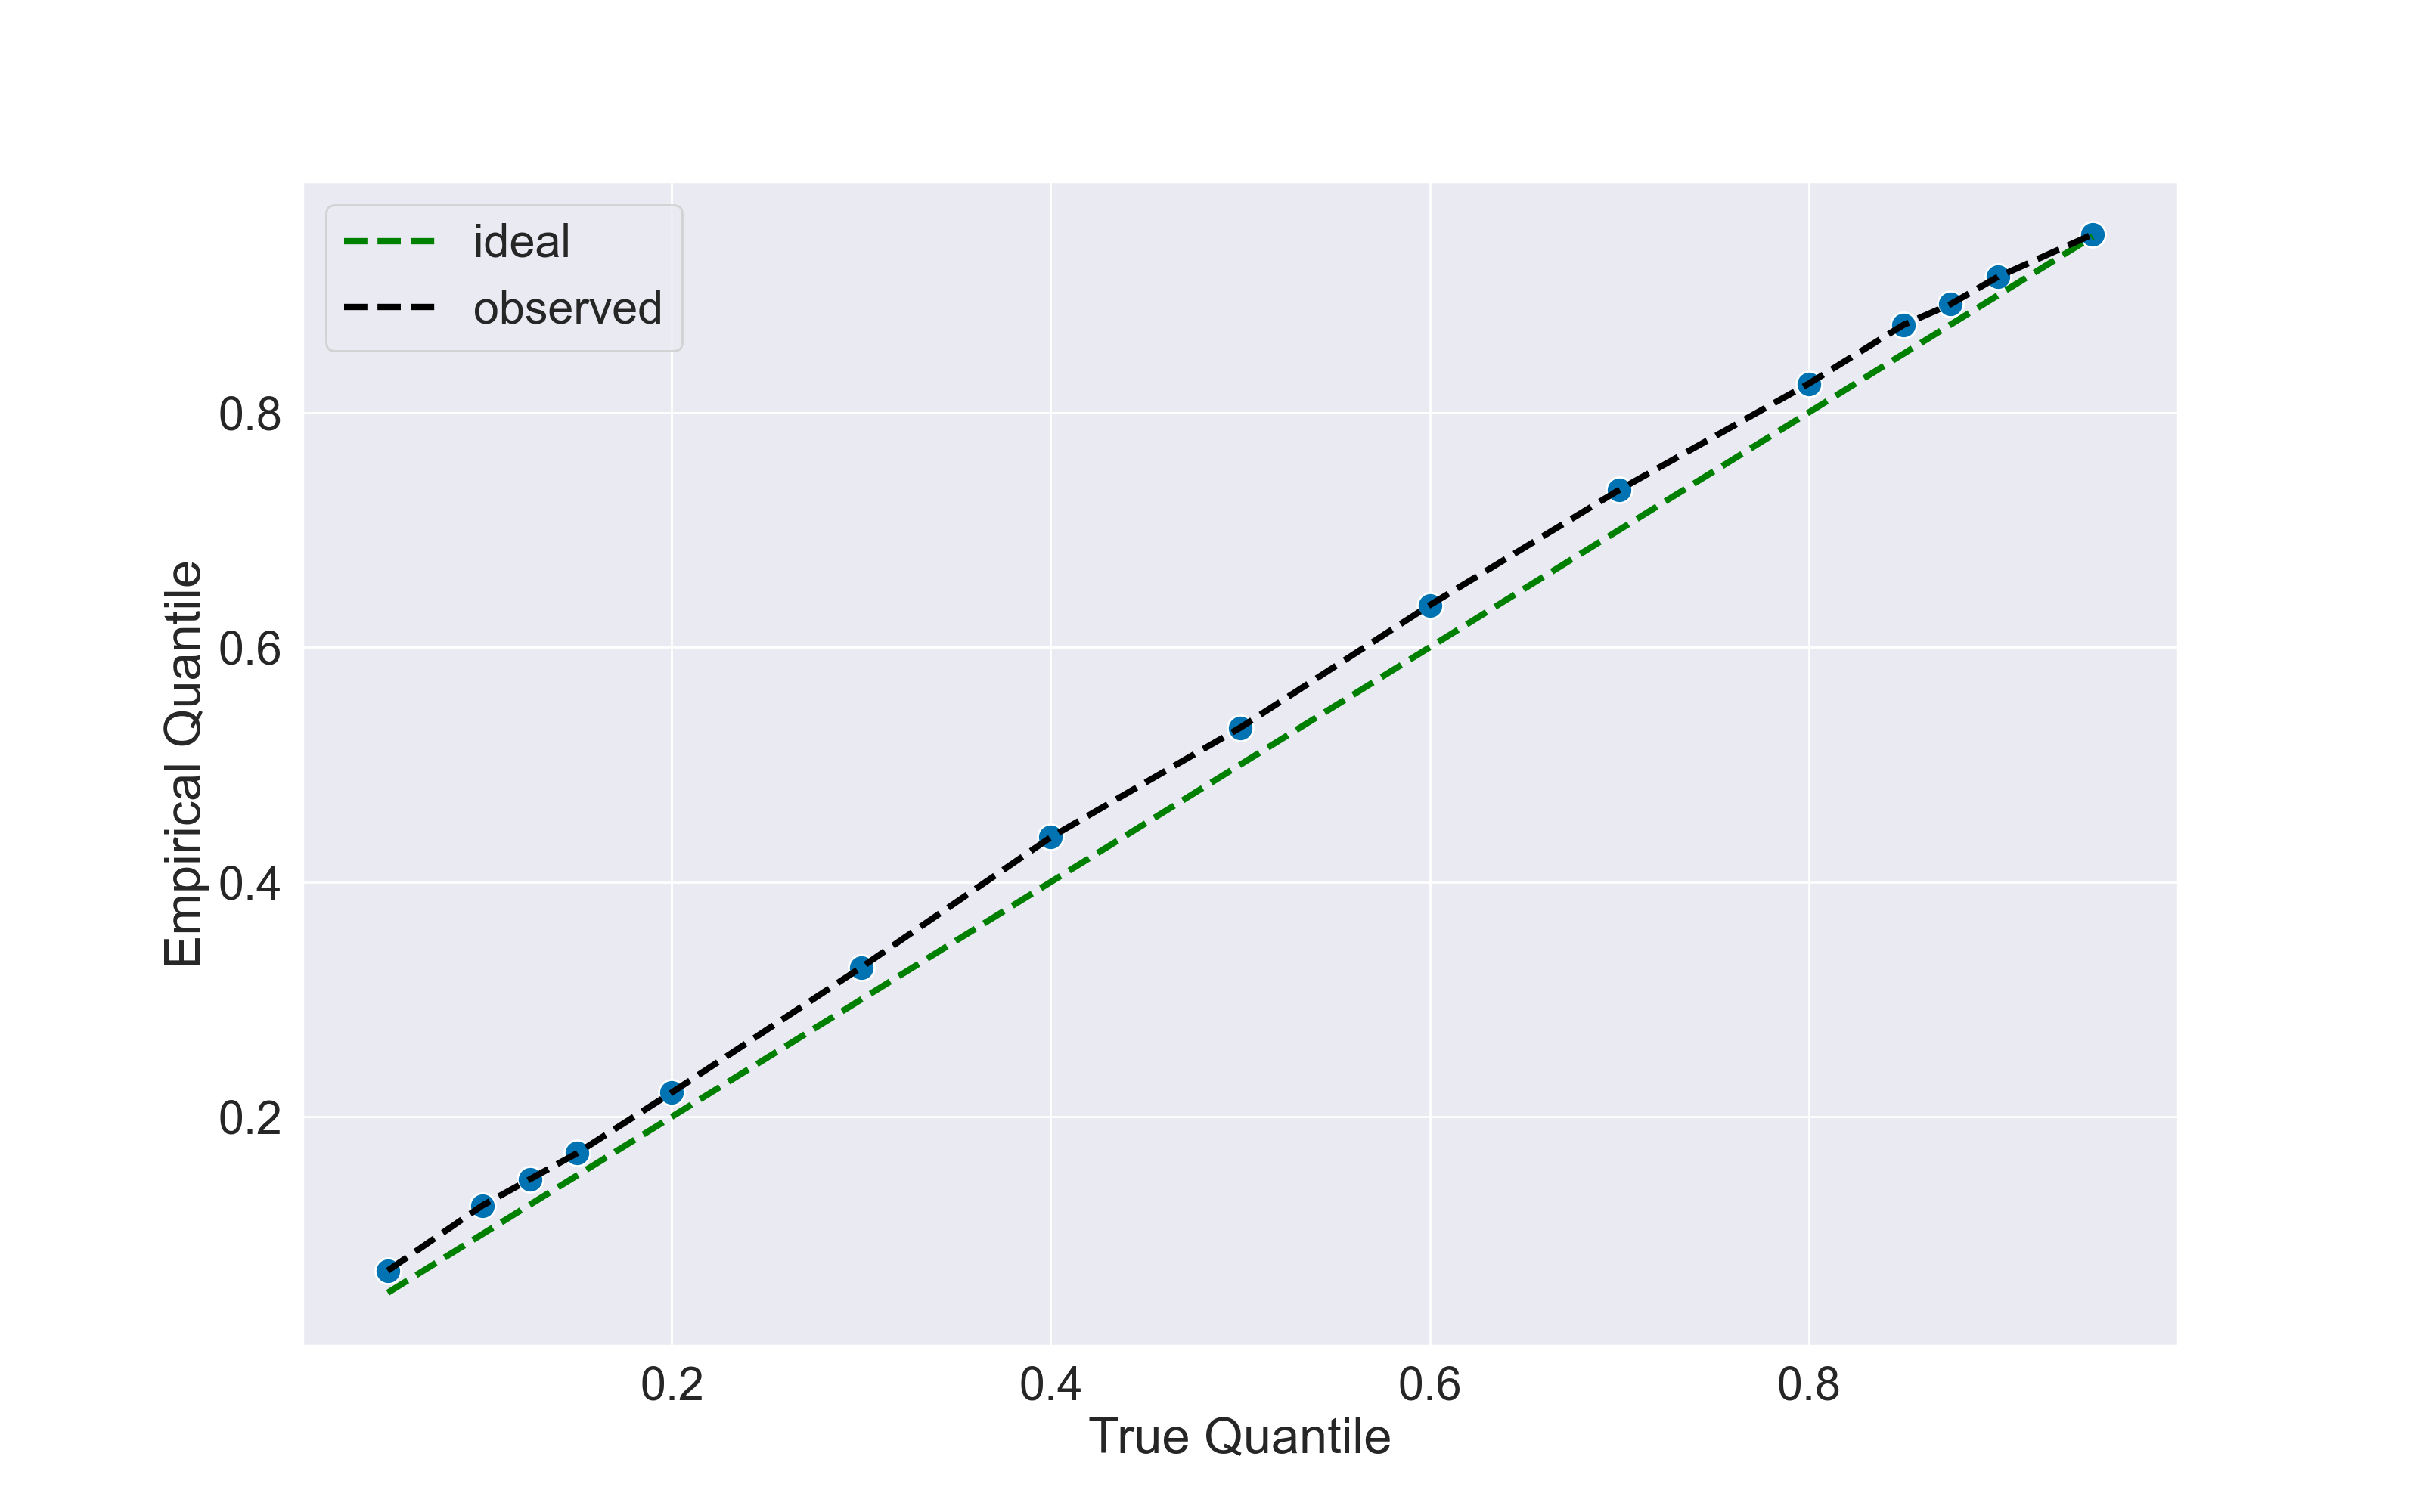

In [97]:
#Reliability diagram
import seaborn as sns

plt.figure(figsize=(16, 10))
sns.set_context("notebook", font_scale=2)
sns.lineplot(x = quantiles, y = quantiles, color = "green", linestyle='--', linewidth=3, label = "ideal")
sns.lineplot(x = quantiles, y = empirical_quantiles, color = "black", linestyle = "dashed", linewidth=3, label = "observed")
sns.scatterplot(x = quantiles, y = empirical_quantiles, marker="o", s = 150)
plt.legend()
plt.xlabel("True Quantile")
plt.ylabel("Empirical Quantile")
#_ = plt.title("Reliability diagram")

In [98]:
#NGB and NN specific results

In [99]:
#comparison_df

from scipy import stats

nll_dl = []
for (true_mean, mean_temp, sd_temp) in zip(y_test, dl_mean_prediction, dl_sd_prediction):
    nll_temp = -stats.norm.logpdf(true_mean, loc = mean_temp, scale = sd_temp)
    nll_dl.append(nll_temp)

    
nll_ngboost = []
for (true_mean, mean_temp, sd_temp) in zip(y_test, ngb_mean_pred, ngb_dist_pred):
    nll_temp = -stats.norm.logpdf(true_mean, loc = mean_temp, scale = sd_temp)
    nll_ngboost.append(nll_temp)

    

comparison_df = pd.DataFrame({'nll_ngboost': nll_ngboost, 'nll_dl': nll_dl, 
                               'true': y_test, 'mean_dl': dl_mean_prediction, 'mean_ngboost': ngb_mean_pred, 
                               'sd_dl': dl_sd_prediction, 'sd_ngboost': ngb_dist_pred
                              }).reset_index(drop=True)
#comparison_df

In [100]:
#plot pdfs and NLL of NGB and NN
def plot_predicted_distribution(index, figsize = (25, 7)):
    row = comparison_df.iloc[index]
    
    true_value = row["true"]
    loc1 = row["mean_dl"]
    loc2 = row["mean_ngboost"]
    
    scale1 = row["sd_dl"]
    scale2 = row["sd_ngboost"]
    
    
    nll_dl =      -stats.norm.logpdf(true_value, loc = loc1, scale = scale1)
    nll_ngboost = -stats.norm.logpdf(true_value, loc = loc2, scale = scale2)
    ############################################################################
    x = np.linspace(min(y_test), max(y_test), 100)

    colors = ["#3a1e73", "#16633f"]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = figsize)
    fig.suptitle('Comparison between DL and NGBoost', y=1.1)

    pdf1 = stats.norm.pdf(x, loc = loc1, scale=scale1)
    ax1.plot(x, pdf1, lw=3, color=colors[0], label=f"$\mu$={np.round(loc1,1)}, $\sigma$={np.round(scale1, 1)}, \ntrue obs = {true_value}")
    ax1.fill_between(x, stats.norm.pdf(x, loc = loc1, scale = scale1), color=colors[0], alpha=.33)
    ax1.legend(fontsize=30)
    ax1.labelsize=30
    ax1.set_ylabel("PDF")
    #ax1.set_xlabel("$x$")
    ax1.set_title(f"NN: NLL = {np.round(nll_dl, 2)}")
    ax1.set_xlim(true_value/2, true_value * 2)
    ax1.vlines(true_value, 0, max(pdf1), 'g', linestyle = "--", label='true label')
    ax1.tick_params(labelsize=20)

    pdf2 = stats.norm.pdf(x, loc = loc2, scale=scale2)
    ax2.plot(x, pdf2, lw=3, color=colors[1], label=f"$\mu$={np.round(loc2, 1)}, $\sigma$={np.round(scale2, 1)}, \ntrue obs = {true_value}")
    ax2.fill_between(x, stats.norm.pdf(x, loc = loc2, scale = scale2), color=colors[1], alpha=.33)
    ax2.legend(fontsize=30)
    ax2.set_ylabel("PDF")
    #ax2.set_xlabel("$x$")
    ax2.set_title(f"NGBoost: NLL = {np.round(nll_ngboost,2)}")
    ax2.set_xlim(true_value/2, true_value * 2)
    ax2.vlines(true_value, 0, max(pdf2), 'g', linestyle = "--", label='true label')
    ax2.tick_params(labelsize=20)
    
    
    ax1.title.set_fontsize(30)
    ax1.xaxis.label.set_fontsize(30)
    ax1.yaxis.label.set_fontsize(30)
    
    
    ax2.title.set_fontsize(30)
    ax2.xaxis.label.set_fontsize(30)
    ax2.yaxis.label.set_fontsize(30)
    
    plt.show()

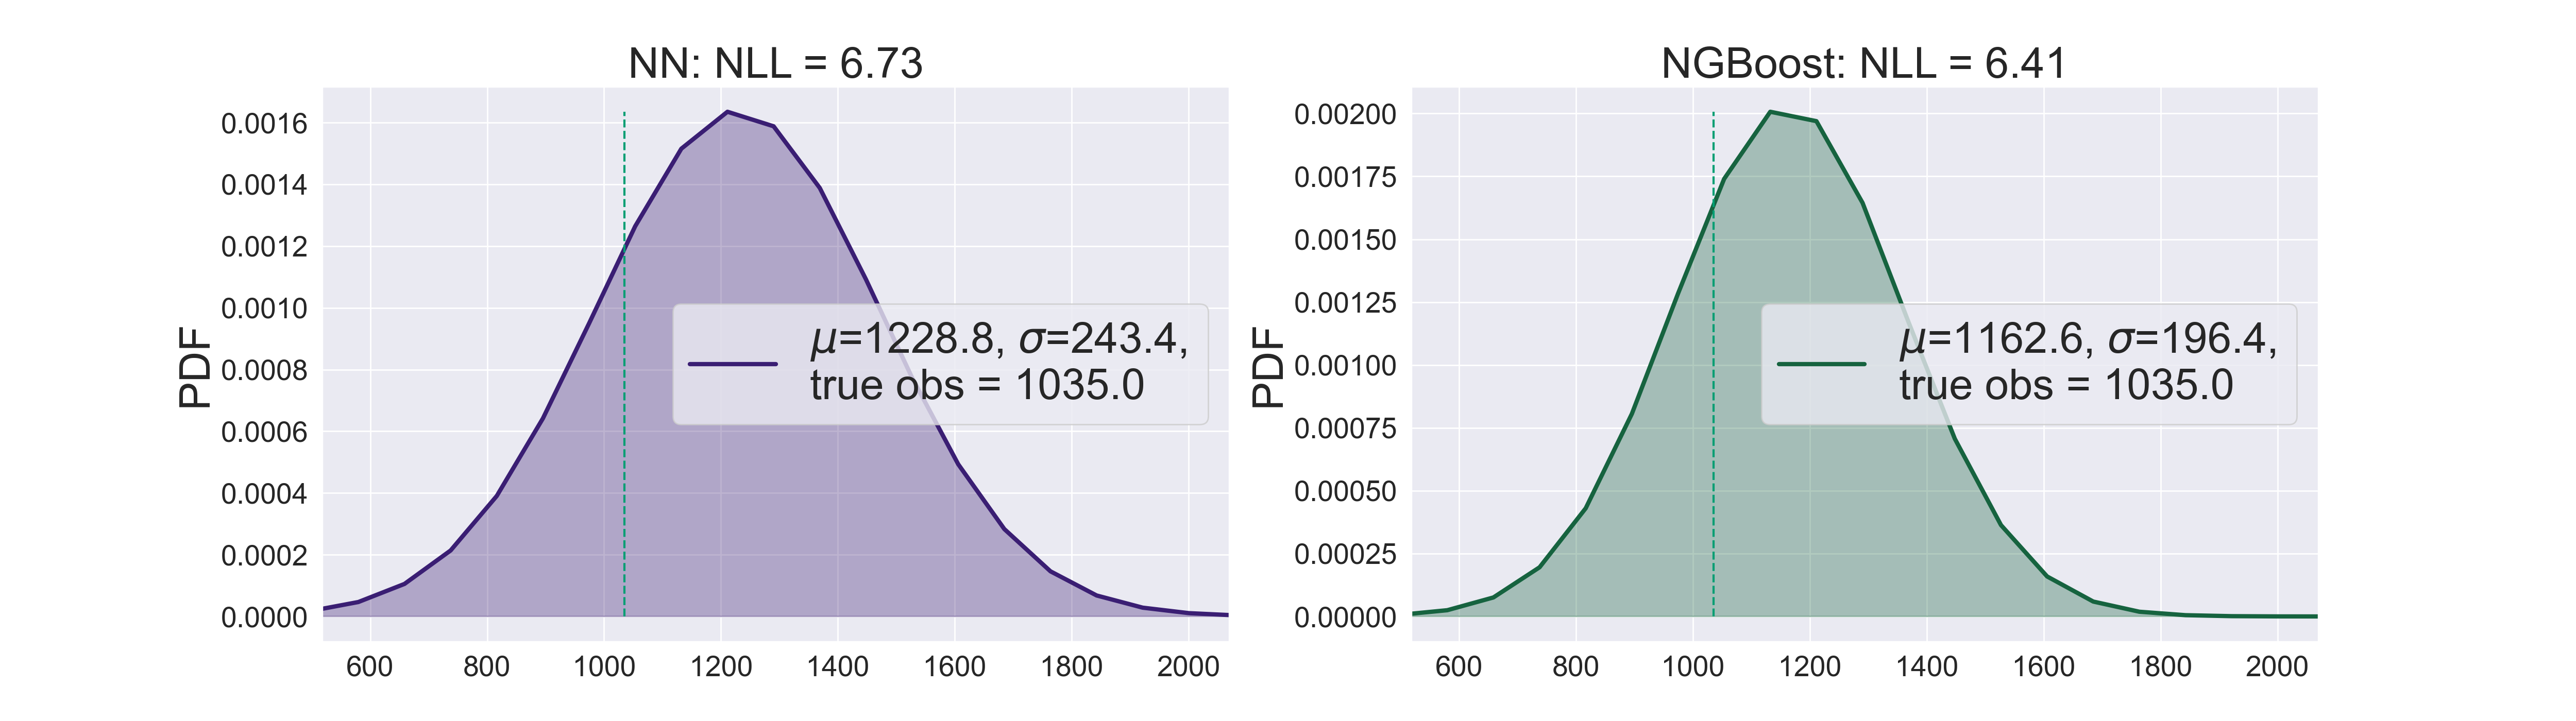

In [101]:
plot_predicted_distribution(0)

In [102]:
#Comparison of all Models

In [103]:
#general regression model quality

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error


lgb_quality = [r2_score(y_test, lgb_prediction),median_absolute_error(y_test, lgb_prediction), np.median(lgb_prediction), np.median(y_test-lgb_prediction)]
bnn_quality = [r2_score(y_test, bnn_mean_values),median_absolute_error(y_test, bnn_mean_values), np.median(bnn_mean_values), np.median(y_test-bnn_mean_values)]
dl_quality = [r2_score(y_test, dl_mean_prediction),median_absolute_error(y_test,dl_mean_prediction), np.median(dl_mean_prediction), np.median(y_test-dl_mean_prediction)]
ngb_quality = [r2_score(y_test, ngb_mean_pred),median_absolute_error(y_test,ngb_mean_pred), np.median(ngb_mean_pred), np.median(y_test-ngb_mean_pred)]

quality_df=pd.DataFrame(data=(lgb_quality, bnn_quality, dl_quality, ngb_quality), columns=["R2", "MAE","mean","median error"], index=["LGB", "BNN", "NN", "NGB"])


quality_df 

,R2,MAE,mean,median error
LGB,0.83,107.39,932.13,-27.21
BNN,0.61,220.19,1047.22,-77.97
NN,0.72,133.55,946.05,-27.75
NGB,0.78,131.94,970.28,-41.37


In [104]:
#correlation of AE/predicted price and uncertainty measure/predicted price, and noramlized correlations

pd.options.display.float_format = '{:.2f}'.format

y_test2=lgb_prediction

#lgb
abs_err=np.abs(y_test.reset_index(drop=True)-lgb_prediction.values)
uncert=quantile_predictions[0.8]-quantile_predictions[0.2]
lgb_corr = np.corrcoef(abs_err, y_test2.values)[0][1]
lgb_corr_norm = np.corrcoef(abs_err/y_test2.values, y_test2.values)[0][1]

lgb_corr2 = np.corrcoef(uncert, y_test2)[0][1]
lgb_corr_norm2 = np.corrcoef(uncert/y_test2, y_test2)[0][1]


y_test2=comparison_df['mean_ngboost']

#ngb
abs_err=np.abs(y_test.reset_index(drop=True)-comparison_df['mean_ngboost'])
uncert=comparison_df['sd_ngboost']
ngb_corr = np.corrcoef(abs_err, y_test2)[0][1]
ngb_corr_norm = np.corrcoef(abs_err/y_test2, y_test2)[0][1]

ngb_corr2 = np.corrcoef(uncert, y_test2)[0][1]
ngb_corr_norm2 = np.corrcoef(uncert/y_test2, y_test2)[0][1]

y_test2=bnn_mean_values

#bnn
abs_err=np.abs(y_test.reset_index(drop=True)-bnn_mean_values[0])
uncert=bnn_std_values[0].values
bnn_corr = np.corrcoef(abs_err, y_test2)[0][1]
bnn_corr_norm = np.corrcoef(abs_err/y_test2, y_test2)[0][1]

bnn_corr2 = np.corrcoef(uncert, y_test2)[0][1]
bnn_corr2_norm = np.corrcoef(uncert/y_test2, y_test2)[0][1]


#bnn_r
abs_err=np.abs(y_test.reset_index(drop=True)-bnn_mean_values[0])
uncert=bnn_range
bnnr_corr = np.corrcoef(abs_err, y_test2)[0][1]
bnnr_corr_norm = np.corrcoef(abs_err/y_test2, y_test2)[0][1]

bnnr_corr2 = np.corrcoef(uncert, y_test2)[0][1]
bnnr_corr2_norm = np.corrcoef(uncert/y_test2, y_test2)[0][1]

y_test2=comparison_df['mean_dl']
#dl
abs_err=np.abs(y_test.reset_index(drop=True)-comparison_df['mean_dl'])
uncert=comparison_df['sd_dl']
dl_corr = np.corrcoef(abs_err, y_test2)[0][1]
dl_corr_norm = np.corrcoef(abs_err/y_test2, y_test2)[0][1]

dl_corr2 = np.corrcoef(uncert, y_test2)[0][1]
dl_corr_norm2 = np.corrcoef(uncert/y_test2, y_test2)[0][1]






lgb_corrs = ["0.2-0.8 quantile range", lgb_corr, lgb_corr_norm, lgb_corr2, lgb_corr_norm2]
ngb_corrs = ["standard deviation", ngb_corr, ngb_corr_norm, ngb_corr2, ngb_corr_norm2]
bnn_corrs = ["prediction standard deviation",bnn_corr, bnn_corr_norm, bnn_corr2, bnn_corr2_norm]
bnnr_corrs = ["prediction range",bnnr_corr, bnnr_corr_norm, bnnr_corr2, bnnr_corr2_norm]
dl_corrs = ["standard deviation",dl_corr, dl_corr_norm, dl_corr2, dl_corr_norm2]


corr_df=pd.DataFrame(data=(lgb_corrs, ngb_corrs, bnn_corrs, bnnr_corrs, dl_corrs), columns=["Measure of uncertainty used", "Correlation AE", "norm. Correlation AE" , "Correlation Unc", "norm. Correlation Unc"], index=["LGB","NGB", "BNN","BNN (range)", "NN"])



corr_df.columns.name = 'Models'

corr_df



Models,Measure of uncertainty used,Correlation AE,norm. Correlation AE,Correlation Unc,norm. Correlation Unc
LGB,0.2-0.8 quantile range,0.52,0.08,0.90,0.18
NGB,standard deviation,0.48,0.08,0.92,-0.19
BNN,prediction standard deviation,0.29,-0.09,0.22,-0.00
BNN (range),prediction range,0.29,-0.09,0.20,-0.01
NN,standard deviation,0.57,0.12,0.66,-0.50


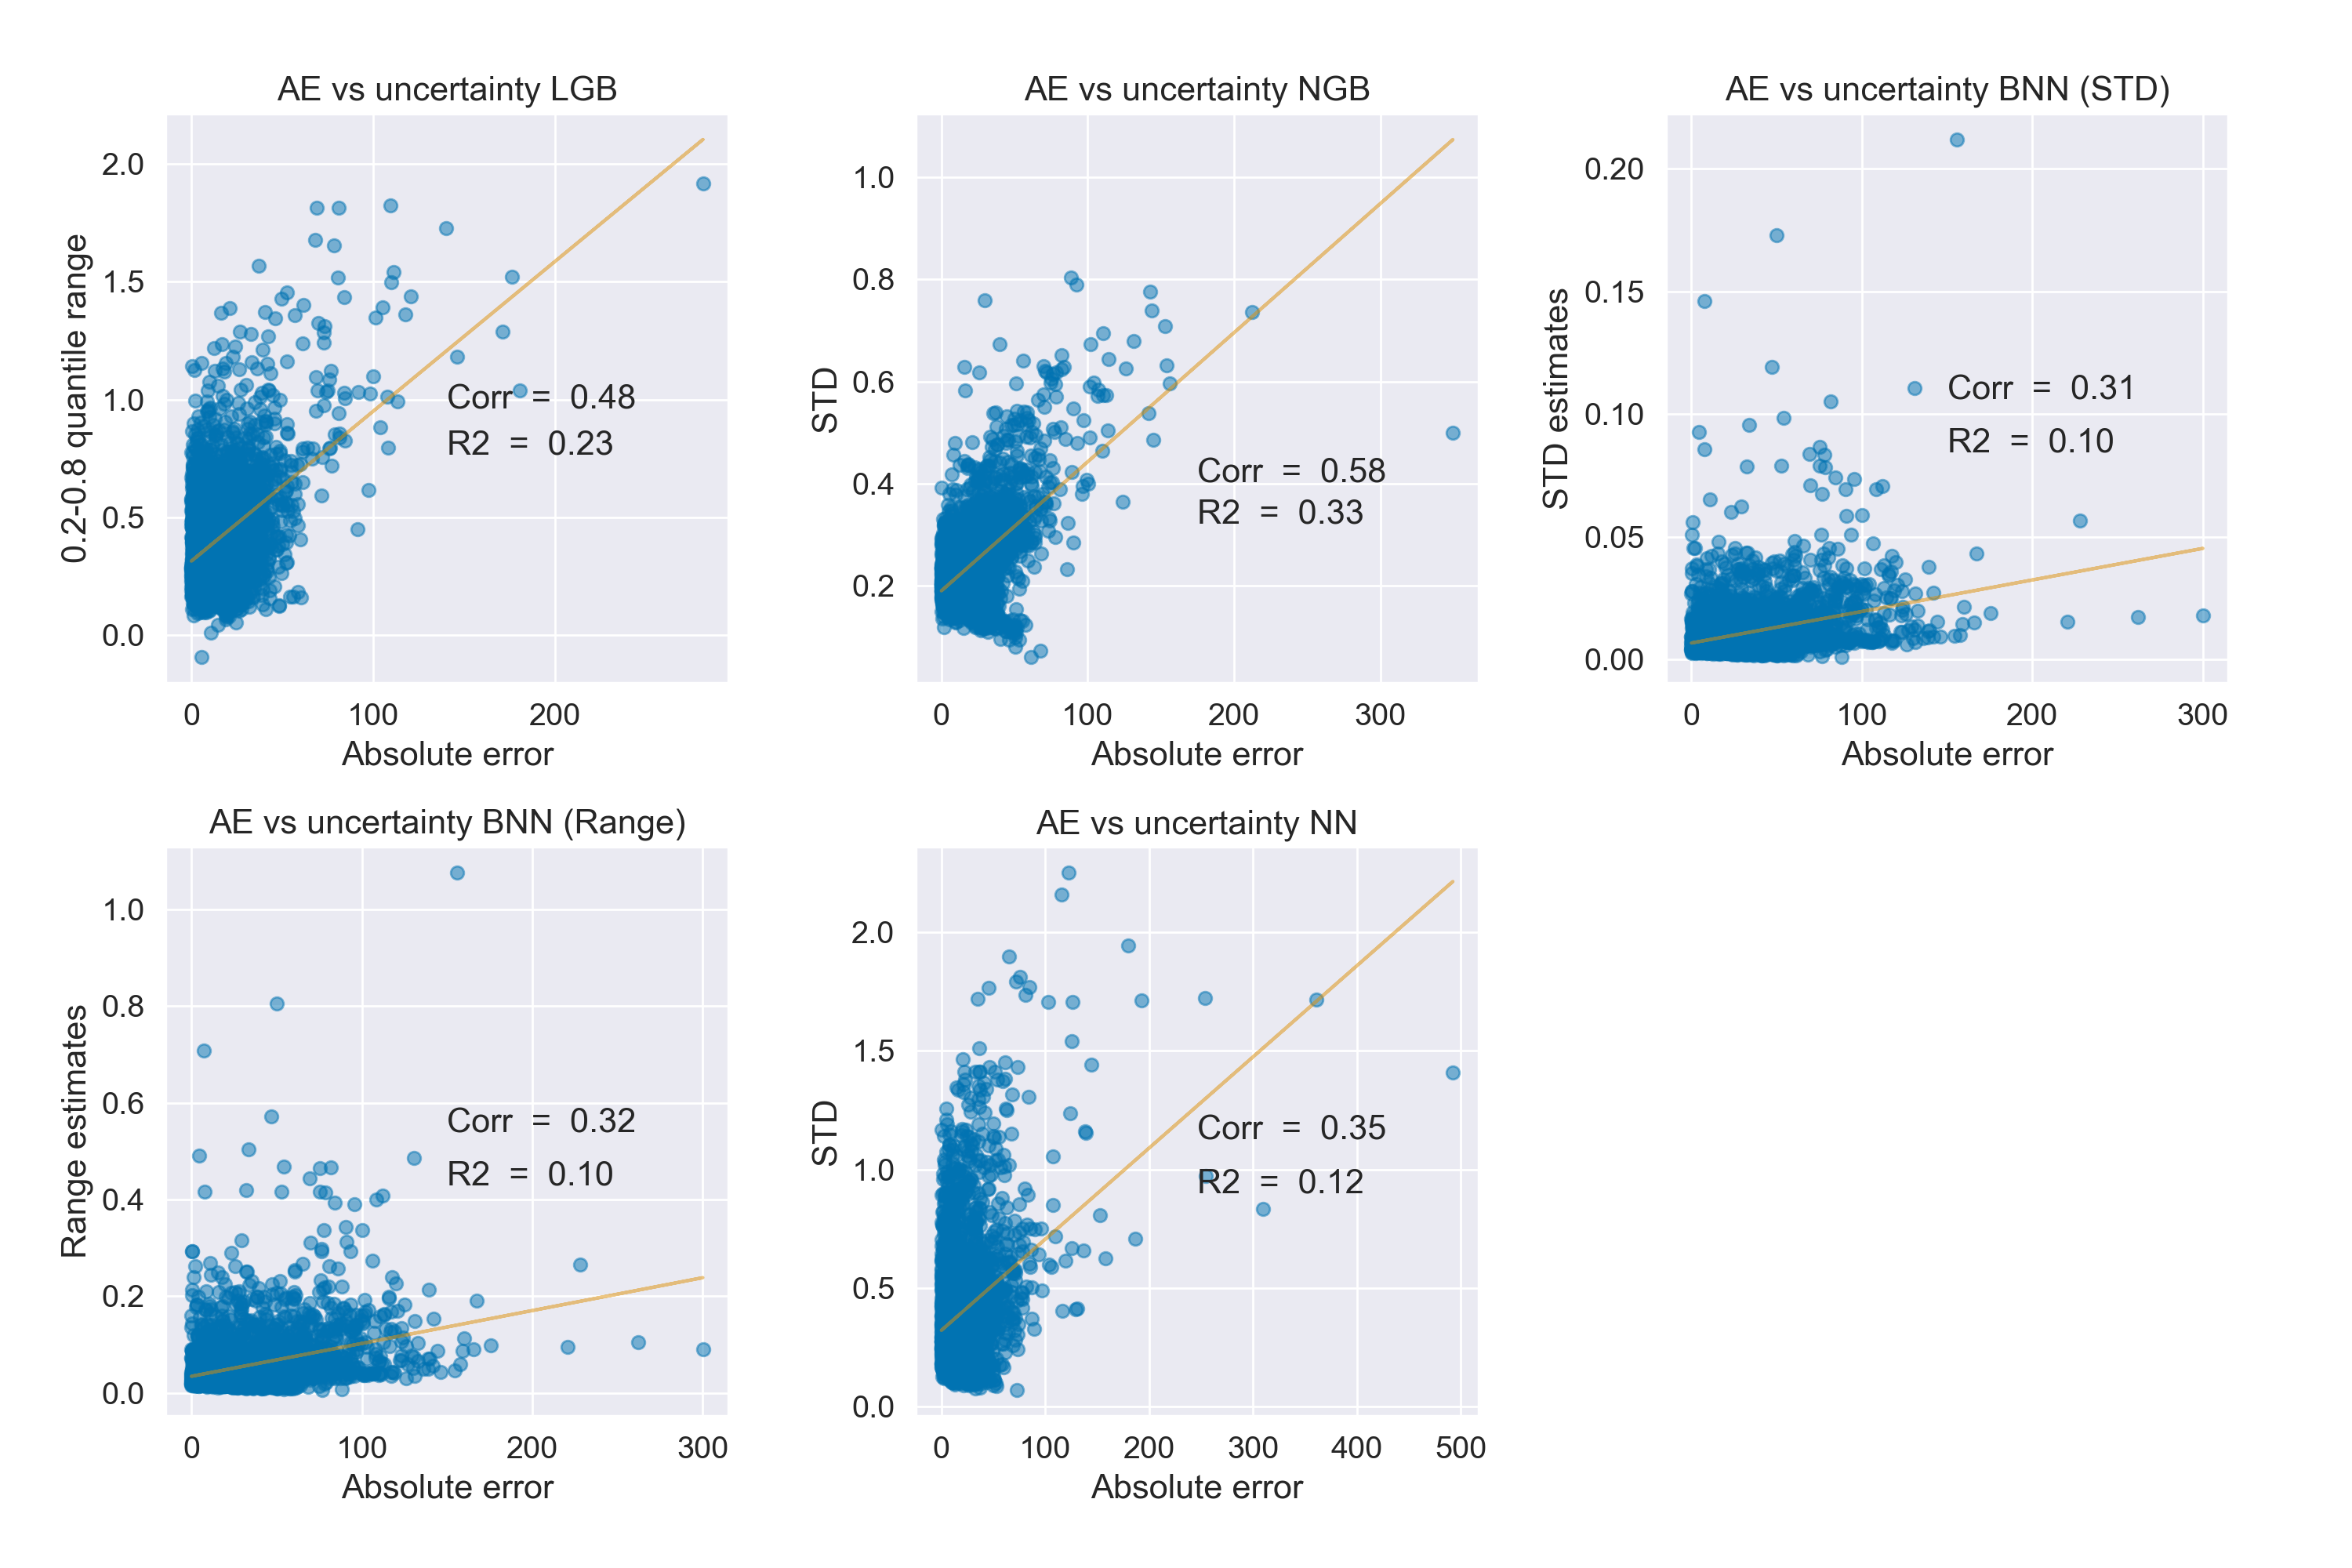

In [105]:
#AE-Uncertainty measure correlation
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()


def plot_absolute_error_vs_uncertainty(y_val, y_hat, std, cur_fig, cur_axis):
    absolute_errors = 100 * (torch.abs(y_hat - y_val)/y_val).detach().numpy().flatten()
    stds = std.detach().numpy().flatten()/y_val
    
    a = absolute_errors
    b = stds
    
    xco= max(absolute_errors)/2
    yco= max(stds)/2
    alpha = 0.5
    
    

    
    #f, ax = plt.subplots(1, 1, figsize=(7, 7))
    cur_axis.scatter(a, b, alpha=alpha)
    
    X = a.reshape((-1, 1))
    y = b
    linreg = LinearRegression().fit(X, y)
    r2 = linreg.score(X, y)
    corr = np.corrcoef(a, b)[0, 1]

    
    y_fit = linreg.coef_[0] * a + linreg.intercept_
    

    
    cur_axis.plot(a, y_fit, '-', color=palette[1], alpha=0.5)

    cur_axis.text(xco, yco, f'Corr  =  {corr:.2f}')
    
    cur_axis.text(xco, yco-yco/5, f'R2  =  {r2:.2f}')
    
    
    return f, cur_axis



#f, ax = plot_absolute_error_vs_uncertainty(y_t.squeeze(1), torch.tensor(bnn_mean_values), torch.tensor(bnn_std_values))


f, axes = plt.subplots(2, 3, figsize=(15, 10))
ax1, ax2 = axes

f.tight_layout(pad=3.0)

    
    
f, ax1[0] = plot_absolute_error_vs_uncertainty(y_t.squeeze(1), torch.tensor(lgb_prediction.values), 
torch.tensor(quantile_predictions[0.8]-quantile_predictions[0.2]), f, ax1[0]) 
    
    
f, ax1[1] = plot_absolute_error_vs_uncertainty(y_t.squeeze(1), torch.tensor(comparison_df['mean_ngboost']), 
torch.tensor(comparison_df['sd_ngboost']), f, ax1[1])  


f, ax1[2] = plot_absolute_error_vs_uncertainty(y_t.squeeze(1), torch.tensor(bnn_mean_values), torch.tensor(bnn_std_values[0]), f, ax1[2])



f, ax2[0] = plot_absolute_error_vs_uncertainty(y_t.squeeze(1), torch.tensor(bnn_mean_values), torch.tensor(bnn_range), f, ax2[0])


f, ax2[1] = plot_absolute_error_vs_uncertainty(y_t.squeeze(1), torch.tensor(comparison_df['mean_dl']), 
torch.tensor(comparison_df['sd_dl']), f, ax2[1])  


f, ax2[2].set_visible(False)



titles=["AE vs uncertainty LGB","AE vs uncertainty NGB","AE vs uncertainty BNN (STD)","AE vs uncertainty BNN (Range)","AE vs uncertainty NN",""]
uncert_measures=["0.2-0.8 quantile range","STD","STD estimates","Range estimates","STD",""]
tcount=0
for i in ax1:
    i.set_title(titles[tcount]);
    
    i.set_xlabel('Absolute error');
    i.set_ylabel(uncert_measures[tcount]);
    
    tcount=tcount+1;
    
for i in ax2:
    i.set_title(titles[tcount]);
    
    i.set_xlabel('Absolute error');
    i.set_ylabel(uncert_measures[tcount]);
    
    tcount=tcount+1;

In [106]:
#Extreme value predictions

def make_predictions(model, x):
    models_result = np.array([model(x).data.numpy() for k in range(100)])
    models_result = models_result[:,:,0]  
    models_result = models_result.T
    mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
    std_values = np.array([models_result[i].std() for i in range(len(models_result))])
    bnn_range = np.array([(models_result[i].max()-models_result[i].min()) for i in range(len(models_result))])

    y_hat = mean_values
    std = std_values
    bnn_range =  bnn_range

    return y_hat, std, bnn_range



#manufacture extreme inputs

X_ges=pd.concat([X_train, X_test])
x=torch.tensor(X_ges.values)   
x = x.type(torch.float32)  

max_input_np = np.zeros((8, x.shape[1]))

for i in range(x.shape[1]):
    max_input_np[0, i] = torch.amax(x[:, i]) * 0.5


for i in range(x.shape[1]):
    max_input_np[1, i] = torch.amax(x[:, i]) * 3
    
    
for i in range(x.shape[1]):
    max_input_np[2, i] = torch.amax(x[:, i]) * 10
    

for i in range(x.shape[1]):
    max_input_np[5, i] = torch.median(x[:, i])    

    
for i in range(x.shape[1]):
    max_input_np[6, i] = torch.mean(x[:, i])

    
for i in range(x.shape[1]):
    max_input_np[7, i] = torch.median(x[:, i]) 

for i in range(7):
    #correct encodings/pointless values
    max_input_np[i,6] = X_ges['latitude'].mean()
    max_input_np[i,7] = X_ges['longitude'].mean()
    max_input_np[i,10] = 1
    max_input_np[i,11] = 0
    max_input_np[i,12] = 0
    max_input_np[i,13] = 1
    max_input_np[i,14] = 0
    max_input_np[i,15] = 0
    max_input_np[i,16] = 1
    max_input_np[i,17] = 0
    max_input_np[i,18] = 1
    max_input_np[i,19] = 0

for i in range(x.shape[1]):
    max_input_np[3, i] = 0


max_input_np[4,0] = -8
max_input_np[4,1] = -33
max_input_np[4,2] = -8
max_input_np[4,3] = -666
max_input_np[4,4] = 0
max_input_np[4,5] = 0
max_input_np[4,6] = 1800
max_input_np[4,7] = 3700
max_input_np[4,8] = -77
max_input_np[4,9] = -99
max_input_np[4,10] = 1
max_input_np[4,11] = 1
max_input_np[4,12] = 1
max_input_np[4,13] = 1
max_input_np[4,14] = 1
max_input_np[4,15] = 1
max_input_np[4,16] = 1
max_input_np[4,17] = 1
max_input_np[4,18] = 1
max_input_np[4,19] = 1
    
    
    
    
#correct encodings/pointless values
max_input_np[5,6] = 37
max_input_np[5,7] = -144
max_input_np[5,10] = 1
max_input_np[5,11] = 1
max_input_np[5,12] = 1
max_input_np[5,13] = 1
max_input_np[5,14] = 1
max_input_np[5,15] = 1
max_input_np[5,16] = 1
max_input_np[5,17] = 1
max_input_np[5,18] = 1
max_input_np[5,19] = 1  
    



#LGB
lgb_max_mean_pred  = lgb_model_predi.predict(max_input_np)
lgb_max_interval_pred = lgb_models[9].predict(max_input_np)-lgb_models[3].predict(max_input_np)




#NN
dl_max_mean_pred  = model_mean.predict(x_scaler.transform(pd.DataFrame(max_input_np, columns=X_train.columns)))#(max_input_np.data.numpy())
dl_max_sd_pred = model_sd.predict(x_scaler.transform(pd.DataFrame(max_input_np, columns=X_train.columns)))#(max_input_np.data.numpy())



#NGB
ngb_max_mean_pred = ngb.predict(max_input_np)
ngb_max_dist_pred = ngb.pred_dist(max_input_np)

ngb_max_mean_pred=ngb_max_mean_pred
ngb_max_dist_pred=ngb_max_dist_pred.params['scale']




#BNN
max_input_bnn = torch.from_numpy(max_input_np)
max_input_bnn = max_input_bnn.type(torch.float32)

mx_bnn_mean_pred, mx_bnn_std, mx_bnn_range = make_predictions(model, max_input_bnn)



lgb_pred=lgb_max_mean_pred.squeeze()
lgb_unc=lgb_max_interval_pred.squeeze()
lgb_unc_coef=lgb_max_interval_pred / lgb_max_mean_pred

ngb_pred=ngb_max_mean_pred.squeeze()
ngb_unc=ngb_max_dist_pred.squeeze()
ngb_unc_coef=ngb_unc/ngb_pred

nn_pred=dl_max_mean_pred.squeeze()
nn_unc=dl_max_sd_pred.squeeze()
nn_unc_coef=nn_unc/nn_pred

bnn_pred=mx_bnn_mean_pred.squeeze()
bnn_unc=mx_bnn_std.squeeze()
bnn_unc_coef=(bnn_unc/bnn_pred)*10







#Extreme value prediction DataFrame
pd.options.display.float_format = '{:.2f}'.format
extreme_values_df=pd.DataFrame(data=(lgb_pred, lgb_unc, lgb_unc_coef, ngb_pred, ngb_unc, ngb_unc_coef,
                   nn_pred, nn_unc, nn_unc_coef,bnn_pred, bnn_unc, bnn_unc_coef), 
                   columns=["x0.5", "x3","x10","zero","neg+nons", "median+nons", "mean", "median" ], 
                   index=["LGB pred", "LGB unc", "LGB unc coef", "NGB pred", "NGB unc", "NGB unc coef",
                   "NN pred", "NN unc", "NN unc coef","BNN pred", "BNN unc", "BNN unc coef"])
extreme_values_df

1/1 [==============================] - 0s 19ms/step


,x0.5,x3,x10,zero,neg+nons,median+nons,mean,median
LGB pred,3870.87,3870.87,3870.87,358.84,537.08,554.62,1329.64,1171.05
LGB unc,2188.22,2264.34,2264.34,237.95,276.04,278.79,415.37,395.26
LGB unc coef,0.57,0.58,0.58,0.66,0.51,0.50,0.31,0.34
NGB pred,4292.70,4624.33,4624.33,477.40,724.70,667.51,1038.52,1022.21
NGB unc,1431.49,1809.72,1809.72,161.79,188.52,143.33,255.27,254.75
NGB unc coef,0.33,0.39,0.39,0.34,0.26,0.21,0.25,0.25
NN pred,9727.61,61413.12,205987.14,84482.64,7068840.00,167696.73,1059.95,988.94
NN unc,2277.21,15431.77,52267.72,59116.69,1655020.38,117705.43,180.34,151.92
NN unc coef,0.23,0.25,0.25,0.70,0.23,0.70,0.17,0.15
BNN pred,15229.75,93596.29,313022.62,5.94,-6836.60,-897.80,1098.66,1033.84


In [107]:
#set quantiles of numerical features

def set_feature_quantile(df, features):
    series = []
    quantiles = np.arange(0., 1., 0.01)
    for q in quantiles:
        series.append(df[features].quantile(q))
  
    def apply_quantile(row):
        v = np.zeros((len(features)))
        
        for i, f in enumerate(features):
            value = row[f]
            for j, q in enumerate(quantiles):
                if value <= series[j][f]:
                    v[i] = q
                    break
        return v.mean()
    
    df['quantile'] = df.apply(apply_quantile, axis=1)
    
    
X_ges=X
X_ges=X_ges[['rooms', 'distance', 'car','building_area',
       'latitude', 'longitude', 'property_count', 'age']]
set_feature_quantile(X_ges, X_ges.columns)
#X_ges['quantile'].hist(bins=20);

C:\Users\User\AppData\Local\Temp\ipykernel_18864\1041363200.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


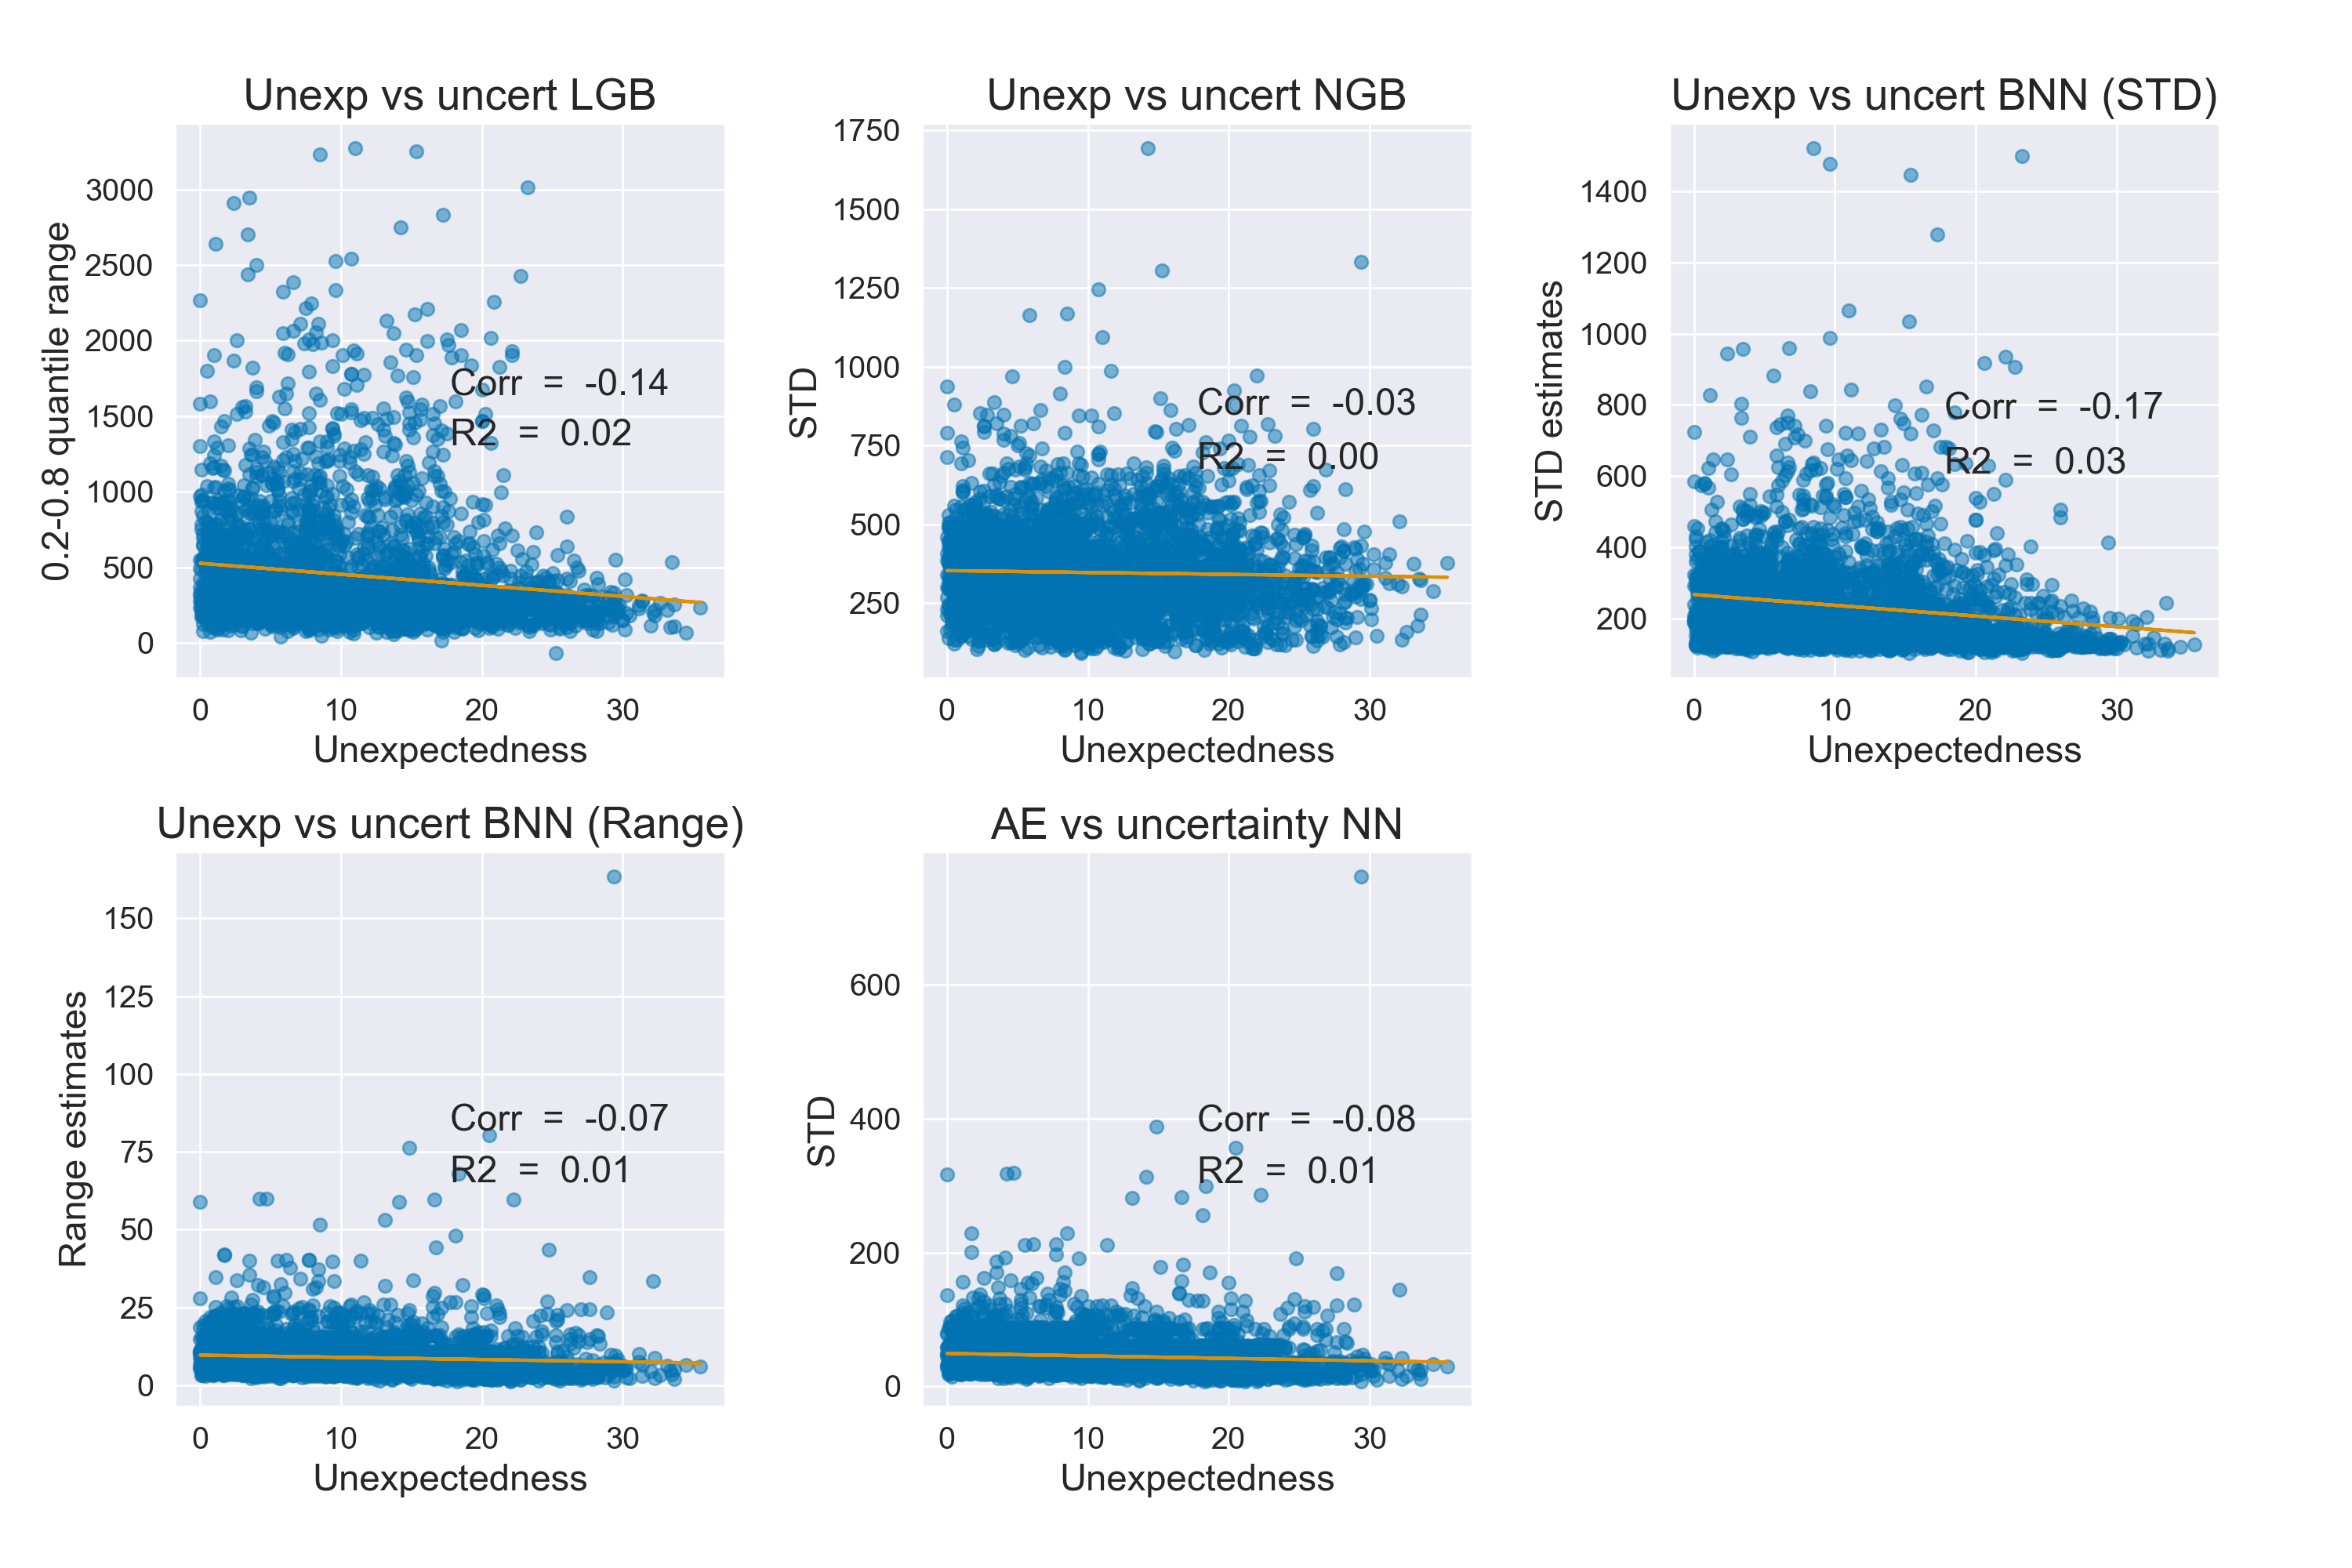

In [108]:
#correlation between uncertainty measures and unexpectedness 

import statsmodels.api as sm



import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 17})

def plot_expectedness_vs_uncertainty(df, test_ix, y_val, std, cur_f, cur_ax):
    quantiles = df['quantile'].iloc[test_ix].values
    expectedness = 100 * np.abs(quantiles - 0.5)

    stds = std

    

    f=cur_f
    ax=cur_ax
    ax.scatter(expectedness, stds, alpha=0.5)
    
    X = sm.add_constant(expectedness.reshape((-1, 1)))
    y = stds.reshape((-1, 1))
    
    linreg = LinearRegression().fit(X, y)
    r2 = linreg.score(X, y)
    
    xco=np.max(expectedness)/2
    yco=np.max(stds)/2
    
    linreg = sm.OLS(y, X).fit()
    y_fit = linreg.predict(X).flatten()
    
    corr = np.corrcoef(expectedness, stds)[0, 1]

    

    
    ax.plot(expectedness, y_fit, '-', color=palette[1], alpha=1)
    
    ax.text(xco, yco, f'Corr  =  {corr:.2f}')
    
    ax.text(xco, yco-yco/5, f'R2  =  {r2:.2f}')
    
    
    return f, ax






f, axes = plt.subplots(2, 3, figsize=(15, 10))
ax1, ax2 = axes

f.tight_layout(pad=3.0)







f, ax1[0] = plot_expectedness_vs_uncertainty(X_ges, test_ix, y_test, (quantile_predictions[0.8]-quantile_predictions[0.2]).values, f, ax1[0]) 


f, ax1[1] = plot_expectedness_vs_uncertainty(X_ges, test_ix, y_test, (comparison_df['sd_dl']).values, f, ax1[1])  
 


f, ax1[2] = plot_expectedness_vs_uncertainty(X_ges, test_ix, y_test, (comparison_df['sd_ngboost']).values, f, ax1[2]) 



f, ax2[0] = plot_expectedness_vs_uncertainty(X_ges, test_ix, y_test, bnn_std_values[0].values, f, ax2[0])


f, ax2[1] = plot_expectedness_vs_uncertainty(X_ges, test_ix, y_test, bnn_range.values, f, ax2[1])


f, ax2[2].set_visible(False)






titles=["Unexp vs uncert LGB","Unexp vs uncert NGB","Unexp vs uncert BNN (STD)","Unexp vs uncert BNN (Range)","AE vs uncertainty NN",""]
uncert_measures=["0.2-0.8 quantile range","STD","STD estimates","Range estimates","STD",""]
tcount=0


for i in range(0,3):
    ax1[i].set_title(titles[tcount], fontsize=20);
    ax1[i].set_xlabel('Unexpectedness');
    ax1[i].set_ylabel(uncert_measures[tcount]);
    tcount=tcount+1;
    
                      
                      
for i in range(0,2):
    ax2[i].set_title(titles[tcount], fontsize=20);
    ax2[i].set_xlabel('Unexpectedness');
    ax2[i].set_ylabel(uncert_measures[tcount]);
    tcount=tcount+1;

In [109]:
#Validity DataFrame

validity_pd = pd.DataFrame()
for interval in [0.6, 0.75, 0.9]:
    #calculate density concentration 
    validity_ngboost = stats.norm.interval(interval, loc = ngb_mean_pred, scale = ngb_dist_pred)
    validity = np.mean((validity_ngboost[0] > y_test) | (y_test > validity_ngboost[1]))
    error=(1-interval)-validity

    validity_pd = pd.concat([validity_pd, pd.DataFrame({'estimator': ['NGBoost'], 'interval': [interval], 'validity': [validity], 'error': [error]})])  

for interval in [0.6, 0.75, 0.9]:
    validity_dl = stats.norm.interval(interval, loc = dl_mean_prediction, scale = dl_sd_prediction)
    validity = np.mean((validity_dl[0] > y_test) | (y_test > validity_dl[1]))
    error=(1-interval)-validity

    validity_pd = pd.concat([validity_pd, pd.DataFrame({'estimator': ['NN'], 'interval': [interval], 'validity': [validity], 'error': [error]})]) 
    

    
for quantile in [(0.2, 0.8), (0.125, 0.875), (0.05, 0.95)]:
    interval = np.round(quantile[1] - quantile[0], 2)
    validity = np.mean((quantile_predictions[quantile[0]] > y_test) | (y_test > quantile_predictions[quantile[1]]))
    error=(1-interval)-validity

    validity_pd = pd.concat([validity_pd, pd.DataFrame({'estimator': ['LGB'], 'interval': [interval], 'validity': [validity], 'interval': [interval], 'error': [error] })]) 
    
validity_pd = validity_pd.reset_index(drop=True).sort_values(by="interval").set_index(["estimator", "interval", "validity", "error"])
validity_pd=validity_pd.reset_index(col_fill=["estimator", "interval", "validity", "error"])
validity_pd=validity_pd.reset_index(drop=True)
#pd.options.display.float_format = '{:.2f}'.format
validity_pd

,estimator,interval,validity,error
0,NGBoost,0.60,0.40,0.00
1,NN,0.60,0.25,0.15
2,LGB,0.60,0.40,0.00
3,NGBoost,0.75,0.24,0.01
4,NN,0.75,0.14,0.11
5,LGB,0.75,0.25,-0.00
6,NGBoost,0.90,0.10,-0.00
7,NN,0.90,0.06,0.04
8,LGB,0.90,0.12,-0.02


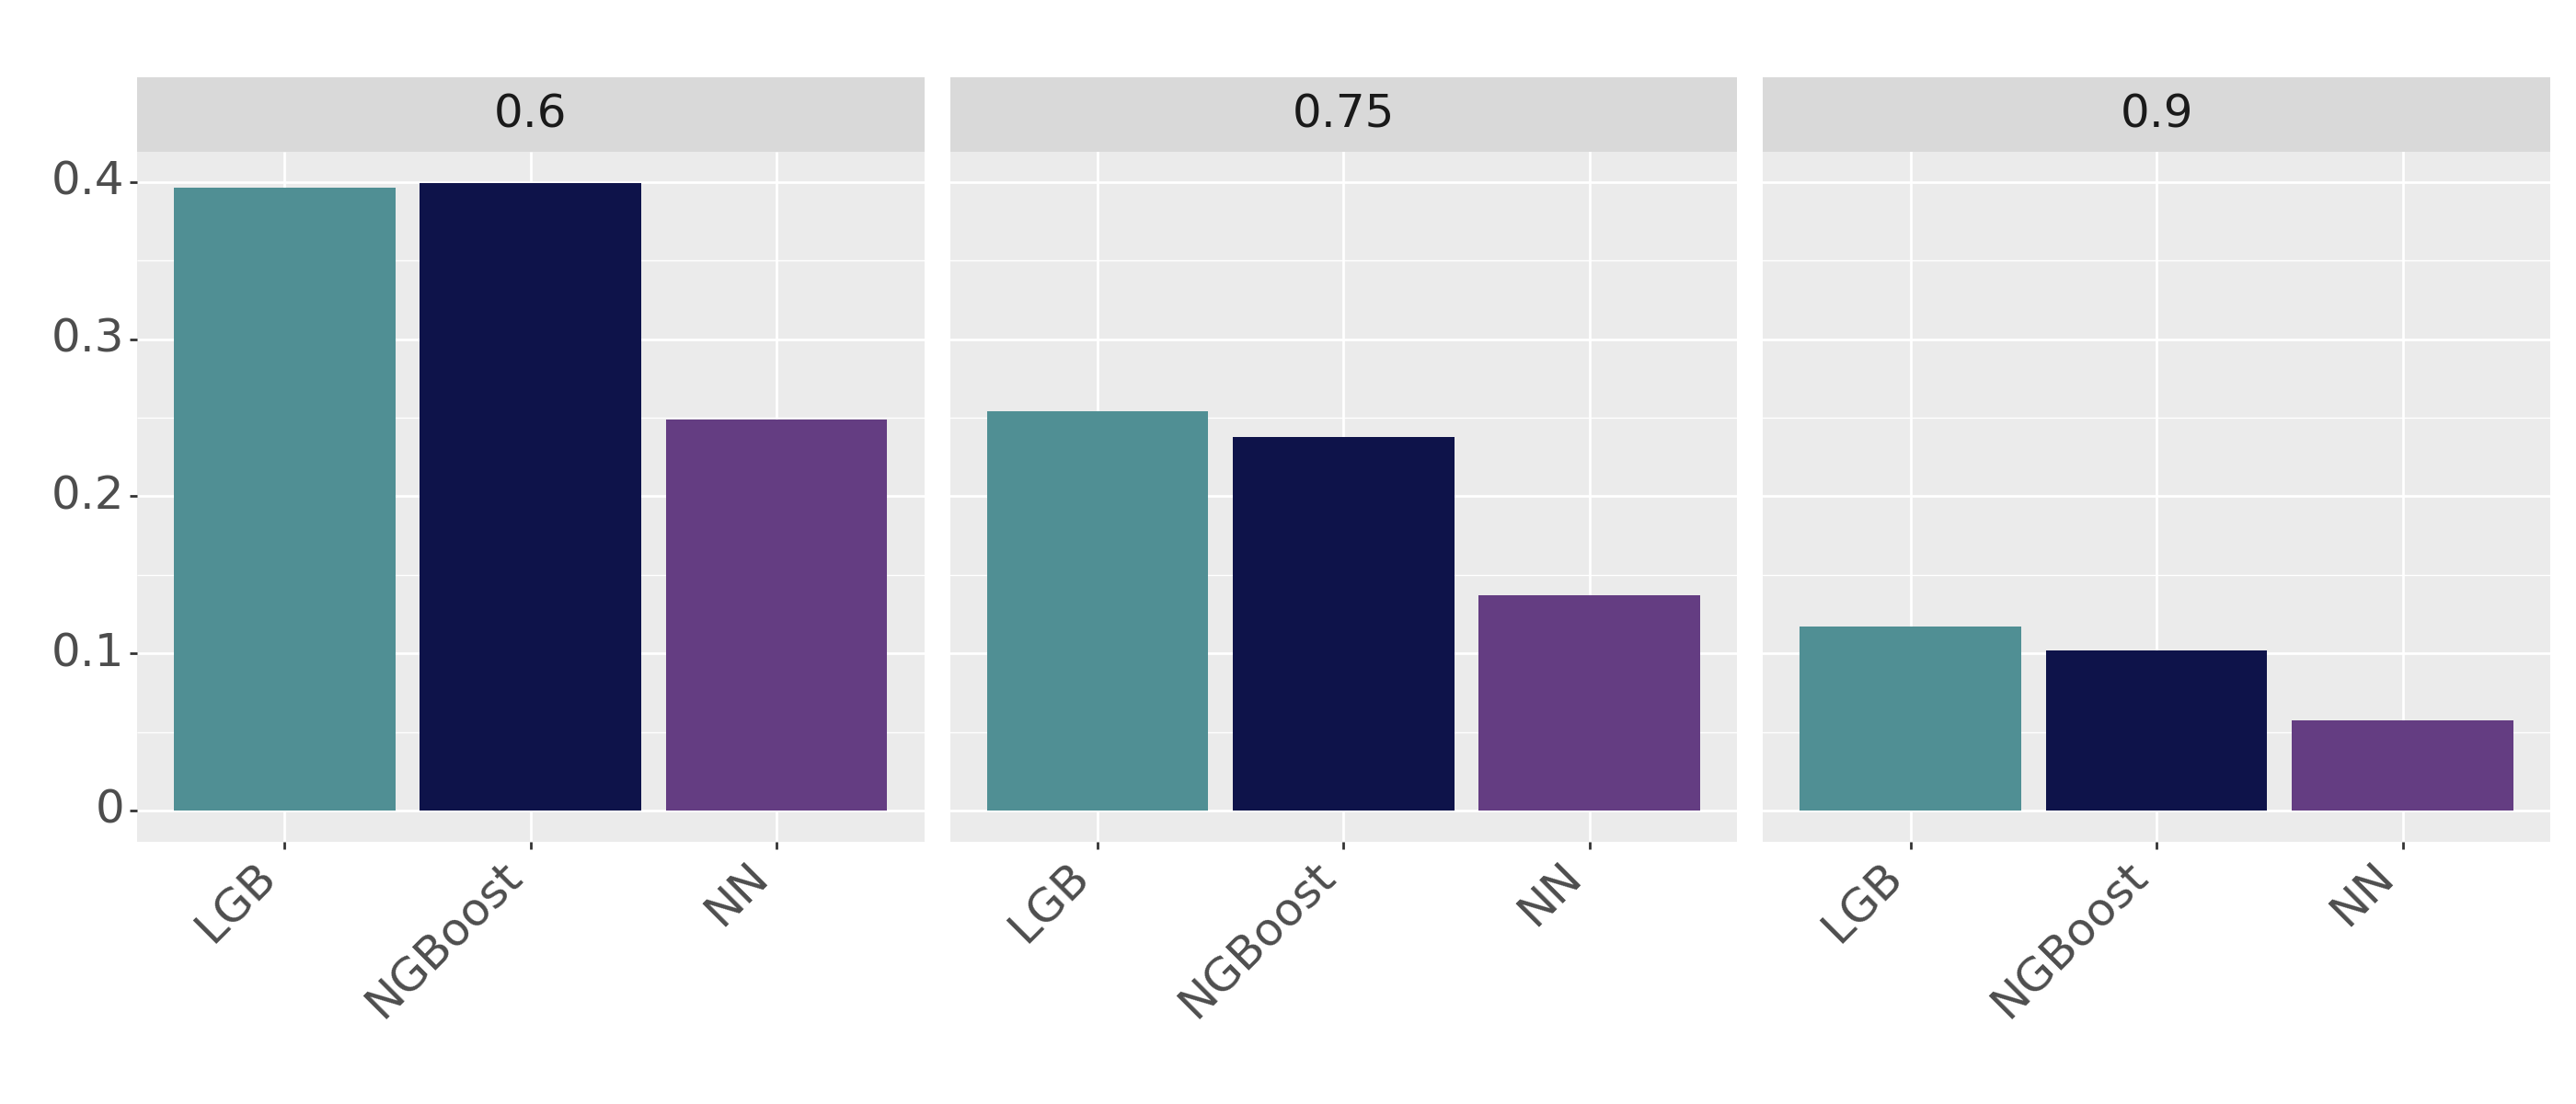

<Figure Size: (1400 x 600)>

In [110]:
#validity plot

import plotnine as p9

valid_plot=p9.ggplot(data=validity_pd, mapping=p9.aes('estimator','validity', fill = "estimator")) \
+ p9.geom_bar( stat = "identity", fill=("#508f94","#0e134a","#643d82") ) + p9.facet_grid('.~ interval') + p9.xlab("") + p9.ylab("") \
+ p9.theme(figure_size=(14, 6), axis_text_x=p9.element_text(rotation=45.0, hjust=1, size=18), \
          axis_text_y=p9.element_text(size=18), text=p9.element_text(size=18))
 # + p9.themes.element_text(size=16))


#valid_plot.save(filename = r'C:\Users\User\Desktop\Melbourne_Housing\Plots\valid_plot.png')





valid_plot

In [111]:
#sharpness dataframe

from scipy import stats

sharpness_pd = pd.DataFrame()

for interval in [0.6, 0.75, 0.9]:
    #calculate density concentration 

    sharpness_ngboost = stats.norm.interval(interval, loc = ngb_mean_pred, scale = ngb_dist_pred)

    value = np.mean(sharpness_ngboost[1] - sharpness_ngboost[0])

    sharpness_pd = pd.concat([sharpness_pd, pd.DataFrame({'estimator': ['NGBoost'], 'interval': [interval], 'width': [value]})])  

for interval in [0.6, 0.75, 0.9]:
    sharpness_dl = stats.norm.interval(interval, loc = dl_mean_prediction, scale = dl_sd_prediction)
    value = np.mean(sharpness_dl[1] - sharpness_dl[0])
    sharpness_pd = pd.concat([sharpness_pd, pd.DataFrame({'estimator': ['NN'], 'interval': [interval], 'width': [value]})])  
             
    
for quantile in [(0.2, 0.8), (0.125, 0.875), (0.05, 0.95)]:
    interval = np.round(quantile[1] - quantile[0], 2)
    value = (quantile_predictions[quantile[1]] - quantile_predictions[quantile[0]]).mean()
    sharpness_pd = pd.concat([sharpness_pd, pd.DataFrame({'estimator': ['LGB'], 'interval': [interval], 'width': [value]})])

sharpness_pd = sharpness_pd.reset_index(drop=True).sort_values(by="interval").set_index(["estimator", "interval"])
sharpness_pd=sharpness_pd.reset_index(col_fill=["estimator", "interval", "width"])
sharpness_pd

,estimator,interval,width
0,NGBoost,0.60,395.35
1,NN,0.60,583.41
2,LGB,0.60,447.61
3,NGBoost,0.75,540.37
4,NN,0.75,797.41
5,LGB,0.75,637.82
6,NGBoost,0.90,772.66
7,NN,0.90,1140.20
8,LGB,0.90,990.97


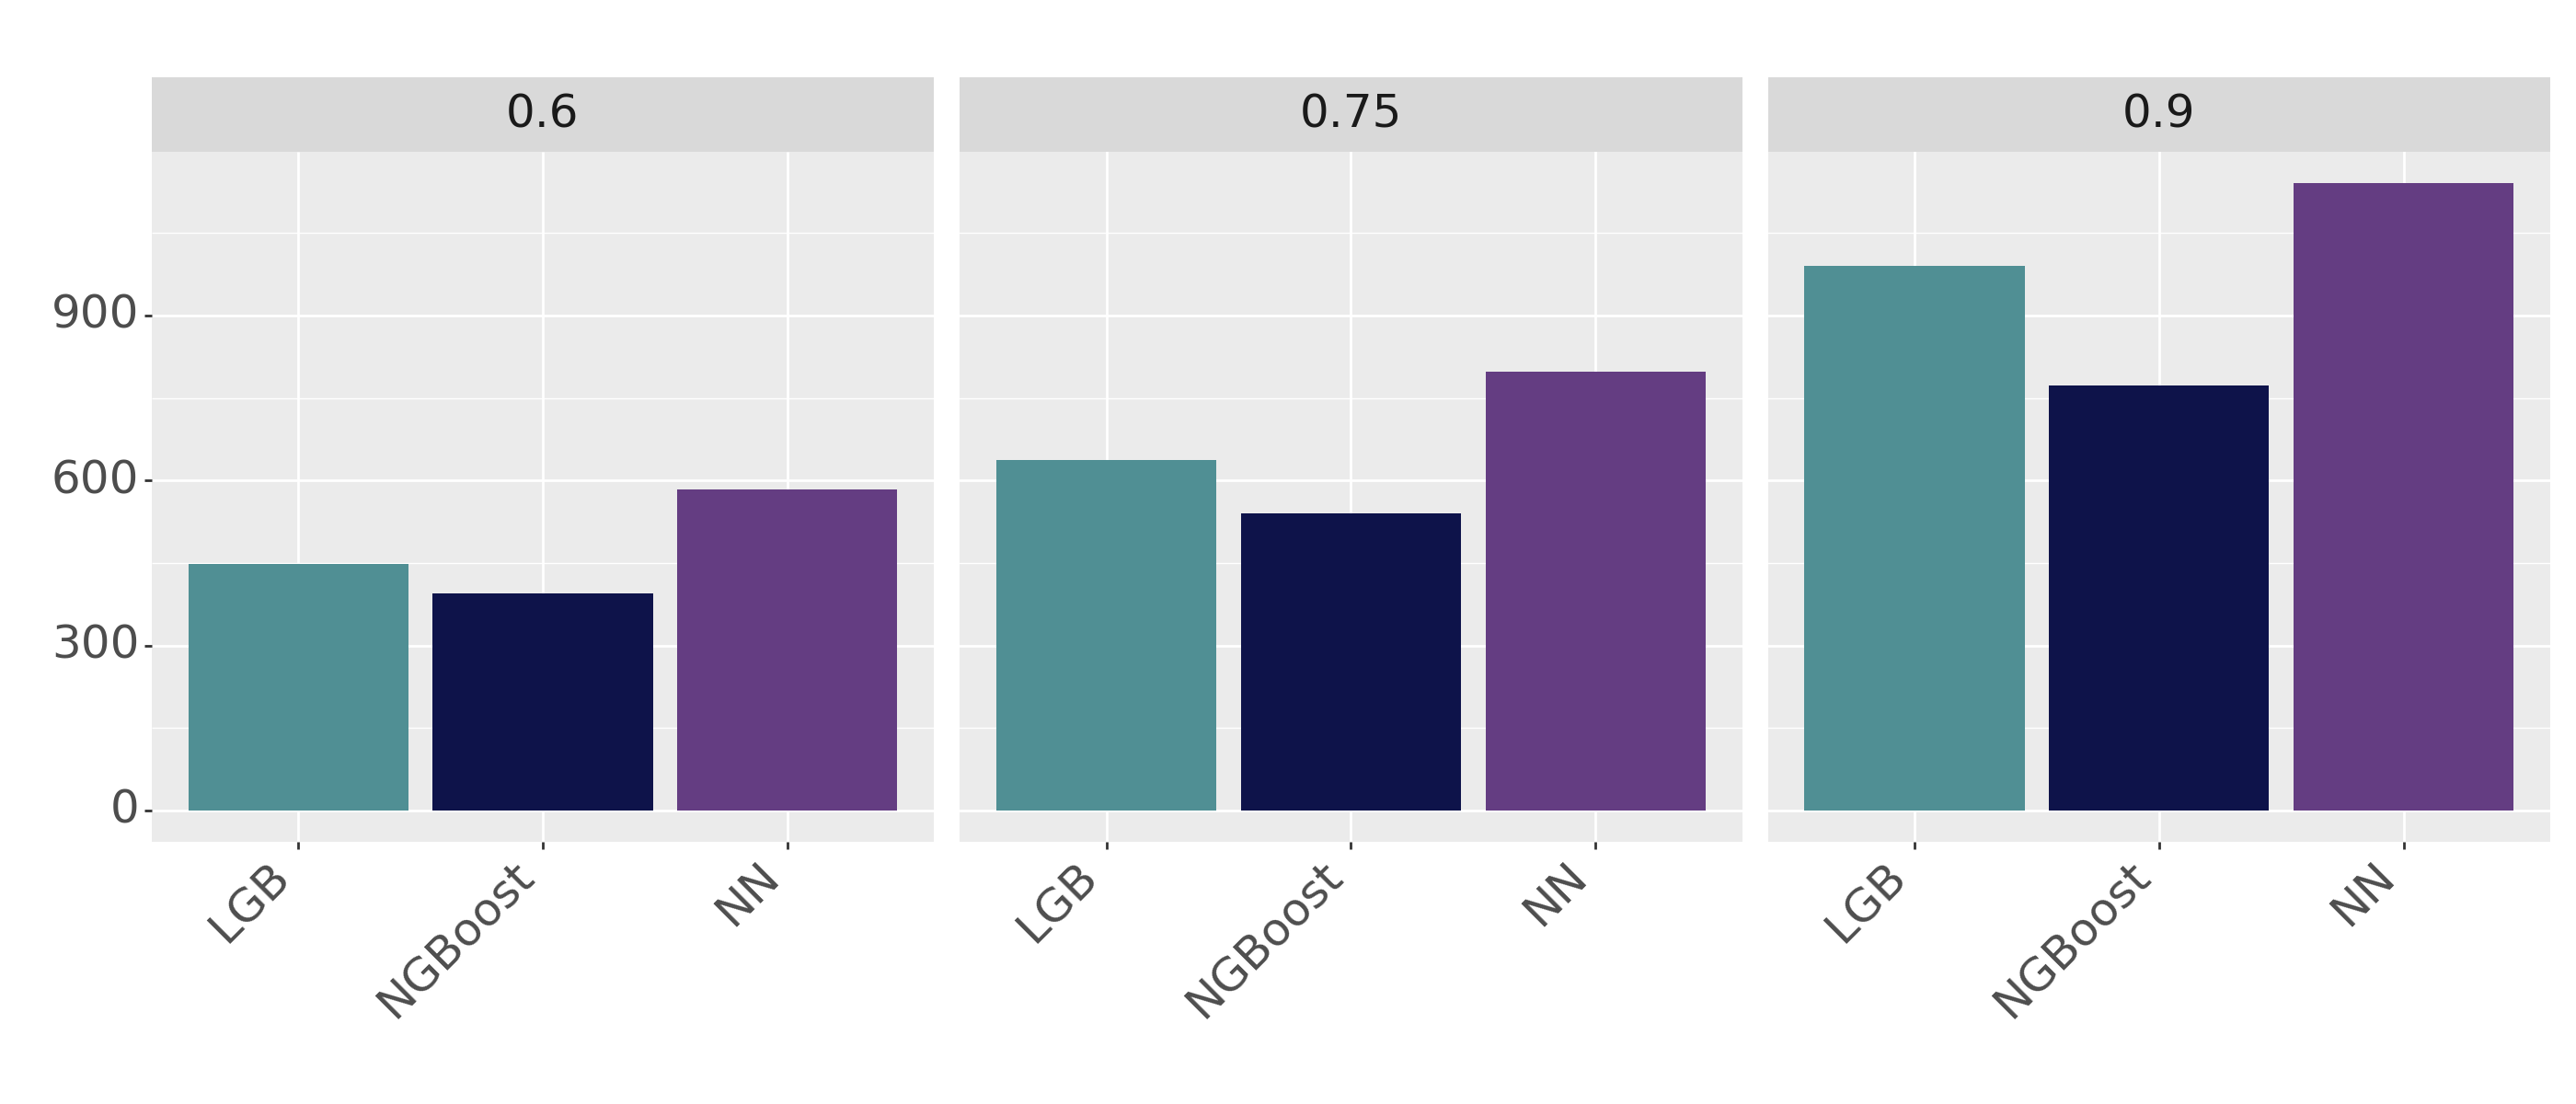

<Figure Size: (1400 x 600)>

In [112]:
#sharpness plot

sharp_plot=p9.ggplot(data=sharpness_pd, mapping=p9.aes('estimator','width', fill = "estimator")) \
+ p9.geom_bar( stat = "identity", fill=("#508f94","#0e134a","#643d82")) + p9.facet_grid('.~ interval') + p9.xlab("") + p9.ylab("") \
+ p9.theme(figure_size=(14, 6), axis_text_x=p9.element_text(rotation=45.0, hjust=1, size=18), \
          axis_text_y=p9.element_text(size=18), text=p9.element_text(size=18))


#sharp_plot.save(filename = r'C:\Users\User\Desktop\Melbourne_Housing\Plots\sharp_plot.png')

sharp_plot

In [113]:
#expanded proerscoring
import properscoring as ps

comparison_df["crps_ngboost"] = comparison_df.apply(lambda x: ps.crps_gaussian(x["true"], mu = x["mean_ngboost"], sig = x["sd_ngboost"]), axis = 1)
comparison_df["crps_dl"] = comparison_df.apply(lambda x: ps.crps_gaussian(x["true"], mu = x["mean_dl"], sig = x["sd_dl"]), axis = 1)

In [114]:
#CRPS and NLL comparison

crps_ngboost=[np.mean(comparison_df["crps_ngboost"]), np.median(comparison_df["crps_ngboost"]), 
              np.mean(comparison_df["nll_ngboost"]), np.median(comparison_df["nll_ngboost"])]
crps_dl=[np.mean(comparison_df["crps_dl"]), np.median(comparison_df["crps_dl"]),
        np.mean(comparison_df["nll_dl"]), np.median(comparison_df["nll_dl"])]



pd.DataFrame(data=(crps_ngboost, crps_dl), index=["CRPS NGB", "CRPS NN"], columns=["mean CRPS", "median CRPS", "mean NLL", "median NLL"])

,mean CRPS,median CRPS,mean NLL,median NLL
CRPS NGB,144.22,88.38,6.86,6.57
CRPS NN,165.39,107.06,7.08,6.89


In [ ]:
#map plotting

def reject_outliers2(data, m=1.5):
    dl_mean=data['sd_dl'].mean()
    dl_std=data['sd_dl'].std()
    
    ngb_mean=data['sd_ngboost'].mean()
    ngb_std=data['sd_ngboost'].std()
    
    bnn_mean=data['sd_bnn'].mean()
    bnn_std=data['sd_bnn'].std()
    
    bnn_range_mean=data['bnn_range'].mean()
    bnn_range_std=data['bnn_range'].std()
    
    lgb_mean=data['sd_lgb'].mean()
    lgb_std=data['sd_lgb'].std()
    
    
    
    data.drop(data[np.abs(data['sd_dl']-dl_mean)>= m* dl_std].index, inplace = True)
    data.drop(data[np.abs(data['sd_ngboost']-ngb_mean)>= m* ngb_std].index, inplace = True)
    data.drop(data[np.abs(data['sd_bnn']-bnn_mean)>= m* bnn_std].index, inplace = True)
    data.drop(data[np.abs(data['bnn_range']-bnn_range_mean)>= m* bnn_range_std].index, inplace = True)
    data.drop(data[np.abs(data['sd_lgb']-lgb_mean)>= m* lgb_std].index, inplace = True)
    
    
    return data


def Extract(lst, number):
    return [item[number] for item in lst]


#added results of all k-fold runs
y_testi=y_test.reset_index(drop=True)
X_test=X.iloc[test_ix].reset_index(drop=True)



#coordinates and uncertainty measures
Data={'latitude':X_test['latitude'].reset_index(drop=True), 'longitude':X_test['longitude'].reset_index(drop=True),
           'sd_dl': comparison_df['sd_dl']/y_testi, 'sd_ngboost': comparison_df['sd_ngboost']/y_testi, 
            'sd_bnn':bnn_std_values[0]/y_testi, 'bnn_range':pd.Series(bnn_range)/y_testi, 
            'sd_lgb': quantile_predictions[0.8]-quantile_predictions[0.2]/y_testi}



coordinates = pd.DataFrame(data=Data)


coordinates=reject_outliers2(coordinates)

            

BBox = ((144.54519887531293, 145.5197506421645,     
         -38.161350176629114, -37.566474603715896))


#plot onto map
#map is in resources
mymap = plt.imread(r'C:\Users\User\Desktop\Melbourne_Housing\map.png')



fig, ax = plt.subplots(figsize = (20,20))
ax.scatter(coordinates['longitude'],  coordinates['latitude'],  c=coordinates['sd_dl'], cmap='YlOrRd', s=10)
ax.set_title('Melbourne Map_dl')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(mymap, zorder=0, extent = BBox, aspect= 'equal')

#fig.savefig(r'C:\Users\User\Desktop\Melbourne_Housing\map_dl.png')


fig1, ax1 = plt.subplots(figsize = (20,20))
ax1.scatter(coordinates['longitude'],  coordinates['latitude'],  c=coordinates['sd_ngboost'], cmap='YlOrRd', s=10)
ax1.set_title('Melbourne Map_ngb')
ax1.set_xlim(BBox[0],BBox[1])
ax1.set_ylim(BBox[2],BBox[3])
ax1.imshow(mymap, zorder=0, extent = BBox, aspect= 'equal')

#fig1.savefig(r'C:\Users\User\Desktop\Melbourne_Housing\map_ngb.png')



fig2, ax2 = plt.subplots(figsize = (20,20))
ax2.scatter(coordinates['longitude'],  coordinates['latitude'],  c=coordinates['sd_bnn'], cmap='YlOrRd', s=10)
ax2.set_title('Melbourne Map_bnn')
ax2.set_xlim(BBox[0],BBox[1])
ax2.set_ylim(BBox[2],BBox[3])
ax2.imshow(mymap, zorder=0, extent = BBox, aspect= 'equal')

#fig2.savefig(r'C:\Users\User\Desktop\Melbourne_Housing\map_bnn.png')



fig3, ax3 = plt.subplots(figsize = (20,20))
ax3.scatter(coordinates['longitude'],  coordinates['latitude'],  c=coordinates['bnn_range'], cmap='YlOrRd', s=10)
ax3.set_title('Melbourne Map_bnn')
ax3.set_xlim(BBox[0],BBox[1])
ax3.set_ylim(BBox[2],BBox[3])
ax3.imshow(mymap, zorder=0, extent = BBox, aspect= 'equal')

#fig3.savefig(r'C:\Users\User\Desktop\Melbourne_Housing\map_bnn_range.png')



fig3, ax3 = plt.subplots(figsize = (20,20))
ax3.scatter(coordinates['longitude'],  coordinates['latitude'],  c=coordinates['sd_lgb'], cmap='YlOrRd', s=10)
ax3.set_title('Melbourne Map_lgb')
ax3.set_xlim(BBox[0],BBox[1])
ax3.set_ylim(BBox[2],BBox[3])
ax3.imshow(mymap, zorder=0, extent = BBox, aspect= 'equal')

#fig3.savefig(r'C:\Users\User\Desktop\Melbourne_Housing\map_lgb.png')

Error in callback <function _draw_all_if_interactive at 0x000001FF85B531C0> (for post_execute):


KeyboardInterrupt: 